In [42]:
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

In [43]:
company_tweet = pd.read_csv('Company_Tweet.csv')
tweet = pd.read_csv('Tweet.csv')
company_value = pd.read_csv('CompanyValues.csv')
company = pd.read_csv('Company.csv')

In [44]:
# Merge the datasets based on 'tweet_id'
socialmedia_dt = pd.merge(company_tweet , tweet , on="tweet_id", how= "inner")

# Display the merged dataset
socialmedia_dt.head(5)

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [45]:
company_value.head(5)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [46]:
socialmedia_dt['post_date'] = pd.to_datetime(socialmedia_dt['post_date'], unit='s')
socialmedia_dt['day_date'] = pd.to_datetime(socialmedia_dt['post_date'].apply(lambda date: date.date()))
socialmedia_dt

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date
0,550803612197457920,AAPL,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01
1,550803612197457920,AMZN,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01
2,550803610825928706,AAPL,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01
3,550803610825928706,GOOGL,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01
4,550803610825928706,AMZN,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01
...,...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,StockJoke,2019-12-31 23:49:06,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0,2019-12-31
4336441,1212159099632267268,TSLA,sweetog76,2019-12-31 23:50:24,$TSLA Very Interesting dude:,0,0,0,2019-12-31
4336442,1212159184931717120,TSLA,MelaynaLokosky,2019-12-31 23:50:45,If only 2020 brought more self-awareness to Te...,0,1,0,2019-12-31
4336443,1212159838882533376,TSLA,ShortingIsFun,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,2019-12-31


In [47]:
from pandas.tseries.offsets import BDay

# Create a DataFrame with all weekdays in the given date range
all_weekdays = pd.date_range(start='2015-01-01', end='2019-12-31', freq=BDay())

# Initialize an empty DataFrame to hold the results
missing_dates = pd.DataFrame()

# Loop over all companies
for company in socialmedia_dt['ticker_symbol'].unique():
    # Filter the DataFrame for the current company
    company_df = socialmedia_dt[socialmedia_dt['ticker_symbol'] == company]
    
    # Find the missing dates by checking if all_weekdays are in the company's 'day_date'
    company_missing_dates = all_weekdays[~all_weekdays.isin(company_df['day_date'])]
    
    # Append the missing dates for the current company to the results DataFrame
    missing_dates = missing_dates.append(pd.DataFrame({
        'ticker_symbol': company,
        'missing_date': company_missing_dates
    }))

# Reset the index of the results DataFrame
missing_dates.reset_index(drop=True, inplace=True)

# Print the missing dates
print(missing_dates)

  ticker_symbol missing_date
0          AAPL   2015-03-25
1          AAPL   2015-07-07
2          AAPL   2015-12-16
3          GOOG   2019-12-06


In [48]:
# Create a DataFrame with all weekdays in the given date range
all_weekdays = pd.date_range(start='2015-01-01', end='2019-12-31', freq=pd.offsets.BDay())

# Initialize a dictionary to hold the results
missing_dates_count = {}

# Loop over all companies
for company in socialmedia_dt['ticker_symbol'].unique():
    # Filter the DataFrame for the current company
    company_df = socialmedia_dt[socialmedia_dt['ticker_symbol'] == company]
    
    # Find the missing dates by checking if all_weekdays are in the company's 'day_date'
    company_missing_dates = all_weekdays[~all_weekdays.isin(company_df['day_date'])]
    
    # Add the count of missing dates for the current company to the results dictionary
    missing_dates_count[company] = len(company_missing_dates)

# Convert the dictionary to a DataFrame
missing_dates_count_df = pd.DataFrame(list(missing_dates_count.items()), columns=['ticker_symbol', 'missing_dates_count'])

# Print the count of missing dates for each company
print(missing_dates_count_df)

  ticker_symbol  missing_dates_count
0          AAPL                    3
1          AMZN                    0
2         GOOGL                    0
3          TSLA                    0
4          GOOG                    1
5          MSFT                    0


In [49]:
# Identify missing values
missing = socialmedia_dt.isnull()

# Count the number of missing values in each column
missing_count = missing.sum()

# Display the missing values and their count
print(missing_count)

tweet_id             0
ticker_symbol        0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
day_date             0
dtype: int64


In [50]:
socialmedia_dt["total_engangement"] = socialmedia_dt["comment_num"] + socialmedia_dt["retweet_num"] + socialmedia_dt["like_num"]
def column_distplot(df, column_name, bins=50, describe=True):
    if describe:
        print(df[column_name].describe())
    plt.figure(figsize=(9, 8))
    sns.distplot(df[column_name], color='g', bins=bins, hist_kws={'alpha': 0.4});

count    4.336445e+06
mean     3.030775e+00
std      1.901432e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.703000e+03
Name: total_engangement, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


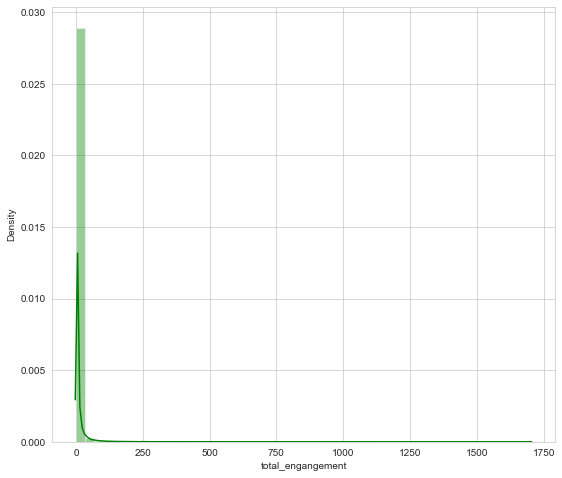

In [51]:
column_distplot(socialmedia_dt, column_name="total_engangement")

In [52]:
def quick_analysis(df):
    print("Data info:")
    print(df.info())
    print("-------------****----------------\n\nData Types:")
    print(df.dtypes)
    print("-------------****----------------\n\nRows and Columns:")
    print(df.shape)
    print("-------------****----------------\n\nColumn names:")
    print(df.columns)
    print("-------------****----------------\n\nNull Values:")
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    print("-------------****----------------\n\nUnique values:")
    print(df.nunique())
    print("-------------****----------------\n\nDescribes:")
    print(df.describe())
    
# Perform quick analysis on each dataset
print("=== Analysis for Company_Tweet ===")
quick_analysis(socialmedia_dt)

print("=== Analysis for CompanyValues ===")
quick_analysis(company_value)

=== Analysis for Company_Tweet ===
Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   tweet_id           int64         
 1   ticker_symbol      object        
 2   writer             object        
 3   post_date          datetime64[ns]
 4   body               object        
 5   comment_num        int64         
 6   retweet_num        int64         
 7   like_num           int64         
 8   day_date           datetime64[ns]
 9   total_engangement  int64         
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 363.9+ MB
None
-------------****----------------

Data Types:
tweet_id                      int64
ticker_symbol                object
writer                       object
post_date            datetime64[ns]
body                         object
comment_num                   int64
retweet_num                   int6

In [53]:
socialmedia_dt

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date,total_engangement
0,550803612197457920,AAPL,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,1
...,...,...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,StockJoke,2019-12-31 23:49:06,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0,2019-12-31,0
4336441,1212159099632267268,TSLA,sweetog76,2019-12-31 23:50:24,$TSLA Very Interesting dude:,0,0,0,2019-12-31,0
4336442,1212159184931717120,TSLA,MelaynaLokosky,2019-12-31 23:50:45,If only 2020 brought more self-awareness to Te...,0,1,0,2019-12-31,1
4336443,1212159838882533376,TSLA,ShortingIsFun,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,2019-12-31,1


In [54]:
traction_rate = 15
socialmedia_dt = socialmedia_dt[socialmedia_dt["total_engangement"] > traction_rate]
socialmedia_dt

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date,total_engangement
40,550781053137616896,AAPL,CNBC,2015-01-01 22:30:10,This is Wall Street's top pick in 2015. Hint: ...,5,37,22,2015-01-01,64
47,550779709840445441,AAPL,WSJ,2015-01-01 22:24:50,"See how tech companies like Apple, Twitter and...",15,223,109,2015-01-01,347
52,550777620422729728,AAPL,philiped,2015-01-01 22:16:32,"New hed, same story: The Apple press goes off ...",7,13,8,2015-01-01,28
86,550752071243141120,AAPL,themotleyfool,2015-01-01 20:35:00,"We're shocked, shocked! that Samsung might try...",2,10,9,2015-01-01,21
169,550690489008394241,AAPL,IBDinvestors,2015-01-01 16:30:18,2015 technology forecasts: Wearable technology...,0,8,11,2015-01-01,19
...,...,...,...,...,...,...,...,...,...,...
4336367,1212117854633562112,TSLA,HedgehogOptions,2019-12-31 21:06:31,Huge huge happy prosperous 2020 to everyone 20...,5,0,23,2019-12-31,28
4336396,1212128015955714048,TSLA,TeslaHistorian,2019-12-31 21:46:53,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2,0,43,2019-12-31,45
4336397,1212128023723556867,TSLA,TeslaHistorian,2019-12-31 21:46:55,"Hey @hchc80, I'm glad $TSLA is neither of thos...",1,0,37,2019-12-31,38
4336399,1212128778786349057,TSLA,ValueAnalyst1,2019-12-31 21:49:55,$TSLA Interesting...$93M trade after hours!Whe...,15,7,64,2019-12-31,86


count    146231.000000
mean         57.212910
std          86.789139
min          16.000000
25%          21.000000
50%          31.000000
75%          57.000000
max        1703.000000
Name: total_engangement, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


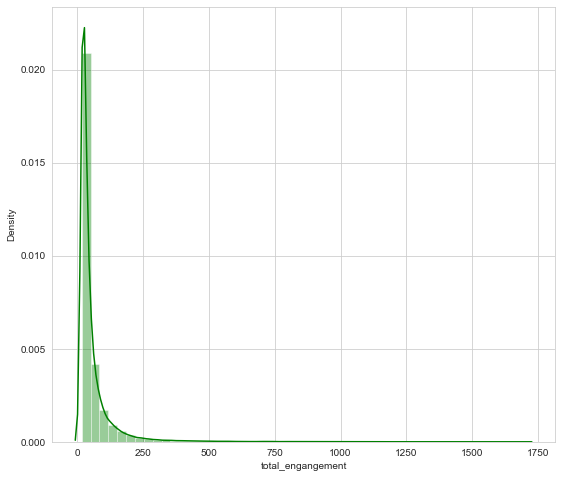

In [55]:
column_distplot(socialmedia_dt, column_name="total_engangement")

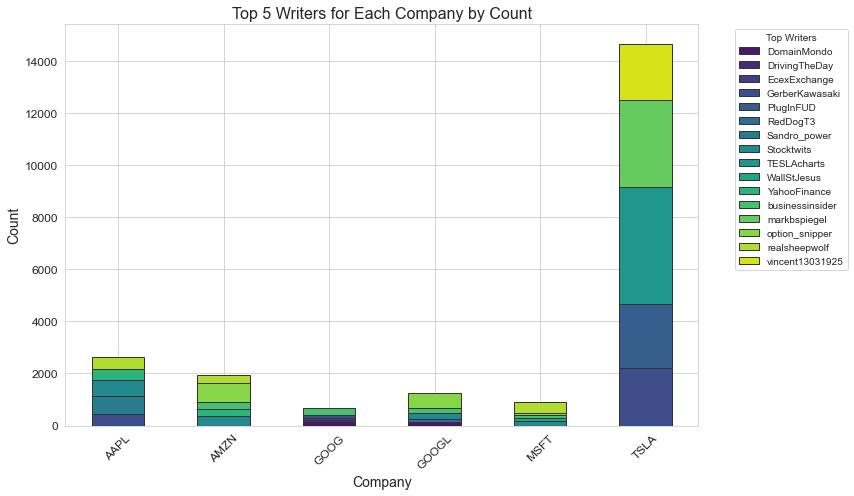

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume df is your socialmedia_dt dataframe
# df = pd.read_csv('path_to_socialmedia_dt.csv')

# Get the top 5 writers for each company based on their post count
top_writers_df = socialmedia_dt.groupby(['ticker_symbol', 'writer']).size().reset_index(name='count')
top_writers_df = top_writers_df.groupby('ticker_symbol').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Pivot table for the stacked bar chart
pivot_df = top_writers_df.pivot(index='ticker_symbol', columns='writer', values='count').fillna(0)

# Visualization
colors = sns.color_palette('viridis', pivot_df.shape[1])
pivot_df.plot(kind='bar', stacked=True, color=colors, figsize=(12, 7), edgecolor='.2')
plt.title("Top 5 Writers for Each Company by Count", fontsize=16)
plt.xlabel("Company", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Top Writers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-57-ab2d705c6bd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socialmedia_dt['tweet_length'] = socialmedia_dt['body'].str.len()


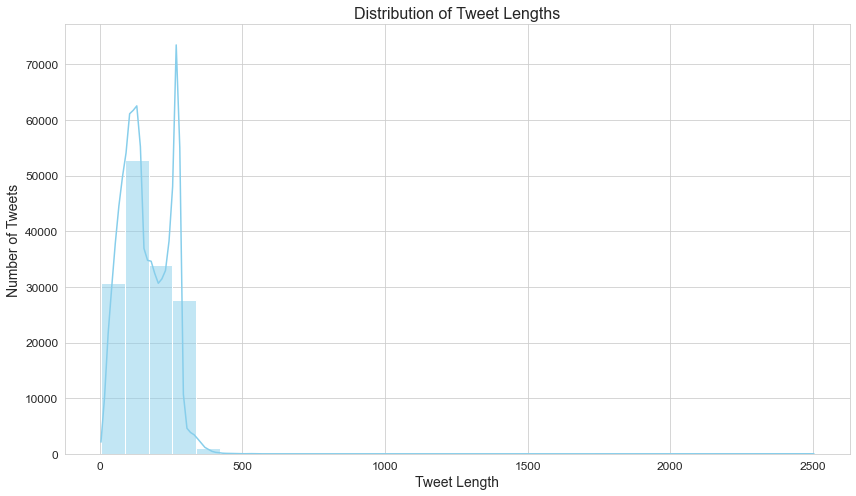

In [57]:
# Calculate the lengths of the tweets
socialmedia_dt['tweet_length'] = socialmedia_dt['body'].str.len()

# Constructing the settings
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the histogram
hist_plot = sns.histplot(socialmedia_dt['tweet_length'], color='skyblue', bins=30, kde=True)

# Title, labels, and aesthetics
plt.title("Distribution of Tweet Lengths", fontsize=16)
plt.xlabel("Tweet Length", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

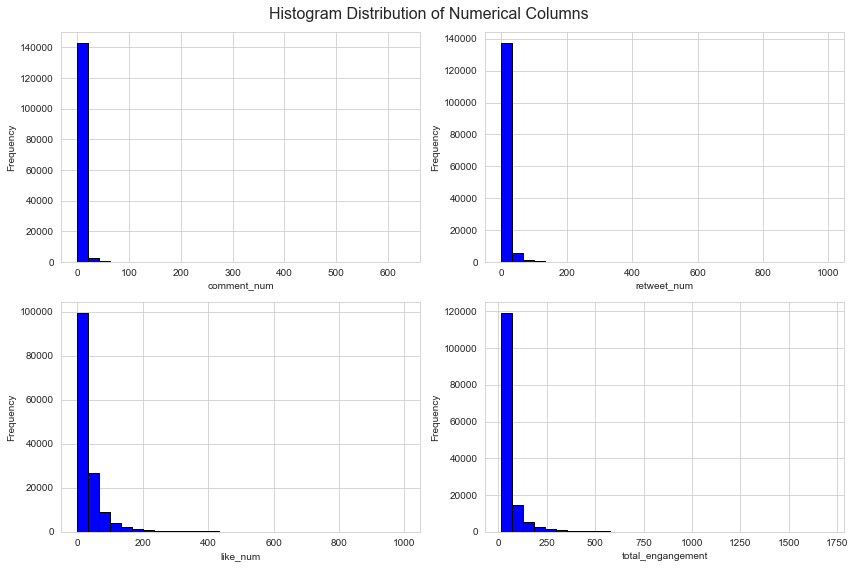

In [58]:
# Select the numerical columns in your dataset
numerical_columns = ['comment_num', 'retweet_num', 'like_num', 'total_engangement']    

# Set the figure size and create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histogram Distribution of Numerical Columns', fontsize=16)

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns):
    ax = axes[i // 2, i % 2]
    ax.hist(socialmedia_dt[column], bins=30, edgecolor='black', color='blue')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [59]:
# Dropping unnecessary columns that will not be used for the sentiment
socialmedia_dt = socialmedia_dt.drop(['tweet_id', 'post_date', 'comment_num', 'retweet_num', 'like_num'], axis=1)
# Dataset information after dropping the columns
print(socialmedia_dt.info())
print()
socialmedia_dt.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146231 entries, 40 to 4336416
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ticker_symbol      146231 non-null  object        
 1   writer             144099 non-null  object        
 2   body               146231 non-null  object        
 3   day_date           146231 non-null  datetime64[ns]
 4   total_engangement  146231 non-null  int64         
 5   tweet_length       146231 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 7.8+ MB
None



,ticker_symbol,writer,body,day_date,total_engangement,tweet_length
3577656,TSLA,eriz35,Reddit guy who programs assembly robots $TSLA,2017-03-08,25,45
3978726,TSLA,stephenpallotta,Last time purchasing gas $tsla,2018-12-06,54,30
155061,AAPL,Sassy_SPY,$AAPL open interest drastically changed today....,2015-04-17,20,95
4088701,TSLA,TESLAcharts,1\ $TSLAQ Stalwarts! I have prepared the follo...,2019-03-28,29,258
421547,AAPL,RedDogT3,$aapl ripped fast. Engulfed all of Thursday. I...,2015-12-04,17,136


In [60]:
# Make a copy of your DataFrame
socialmedia_dt_copy = socialmedia_dt.copy()

In [61]:
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords
nltk.download('wordnet')  # For lemmatization

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Custom stopword list, keeping 'not' and other potential negations
    stop_words = set(stopwords.words("english")) - {'not', 'nor', 'no'}
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# Apply preprocessing to the 'body' column
socialmedia_dt_copy['preprocessed_body'] = socialmedia_dt_copy['body'].apply(preprocess_text)

# Load the sentiment analysis model
sentiment_classifier = pipeline("sentiment-analysis")

# Adjust the max length to be within model's limit
max_sequence_length = 512

# Function to split long text into sentences while adhering to the max length
def split_into_sentences(text, max_length):
    sentences = sent_tokenize(text)
    short_sentences = []
    current_sentence = ''
    for sentence in sentences:
        if len(current_sentence) + len(sentence) <= max_length:
            current_sentence += ' ' + sentence
        else:
            short_sentences.append(current_sentence)
            current_sentence = sentence
    short_sentences.append(current_sentence)
    return short_sentences

# Apply the split_into_sentences function to create tweet segments
socialmedia_dt_copy["segments"] = socialmedia_dt_copy["preprocessed_body"].apply(lambda x: split_into_sentences(x, max_sequence_length))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [62]:
socialmedia_dt_copy

,ticker_symbol,writer,body,day_date,total_engangement,tweet_length,preprocessed_body,segments
40,AAPL,CNBC,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,64,94,wall street top pick hint not aapl googl,[ wall street top pick hint not aapl googl]
47,AAPL,WSJ,"See how tech companies like Apple, Twitter and...",2015-01-01,347,119,see tech company like apple twitter facebook r...,[ see tech company like apple twitter facebook...
52,AAPL,philiped,"New hed, same story: The Apple press goes off ...",2015-01-01,28,163,new hed story apple press go halfcocked aapl,[ new hed story apple press go halfcocked aapl]
86,AAPL,themotleyfool,"We're shocked, shocked! that Samsung might try...",2015-01-01,21,125,shocked shocked samsung might try copy somethi...,[ shocked shocked samsung might try copy somet...
169,AAPL,IBDinvestors,2015 technology forecasts: Wearable technology...,2015-01-01,19,126,technology forecast wearable technology innova...,[ technology forecast wearable technology inno...
...,...,...,...,...,...,...,...,...
4336367,TSLA,HedgehogOptions,Huge huge happy prosperous 2020 to everyone 20...,2019-12-31,28,215,huge huge happy prosperous everyone trader dre...,[ huge huge happy prosperous everyone trader d...
4336396,TSLA,TeslaHistorian,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2019-12-31,45,50,hey chrisspelter mean tsla worthy,[ hey chrisspelter mean tsla worthy]
4336397,TSLA,TeslaHistorian,"Hey @hchc80, I'm glad $TSLA is neither of thos...",2019-12-31,38,53,hey hchc im glad tsla neither,[ hey hchc im glad tsla neither]
4336399,TSLA,ValueAnalyst1,$TSLA Interesting...$93M trade after hours!Whe...,2019-12-31,86,70,tsla interestingm trade hourswhere hour ago,[ tsla interestingm trade hourswhere hour ago]


In [63]:
socialmedia_dt_copy1 = socialmedia_dt_copy.copy()

In [71]:
socialmedia_dt_copy2 = socialmedia_dt_copy.copy()

In [ ]:
socialmedia_dt_copy3 = socialmedia_dt_copy.copy()

In [64]:
socialmedia_dt_copy4 = socialmedia_dt_copy.copy()

In [81]:
# Extract sentiment from each tweet segment
sentiment_labels = []
sentiment_scores = []

for segments in socialmedia_dt_copy1["segments"]:
    segment_sentiments = [sentiment_classifier(segment)[0] for segment in segments]
    # Aggregating the sentiment scores with mean for each tweet
    mean_sentiment_score = sum([sentiment['score'] for sentiment in segment_sentiments]) / len(segment_sentiments)
    sentiment_scores.append(mean_sentiment_score)

    # Calculate label based on mean sentiment score
    if mean_sentiment_score > 0.66:
        sentiment_labels.append('POSITIVE')
    elif mean_sentiment_score <= 0.33:
        sentiment_labels.append('NEGATIVE')
    else:
        sentiment_labels.append('NEUTRAL')

# Add sentiment label and score columns to the DataFrame
socialmedia_dt_copy1["sentiment_label"] = sentiment_labels
socialmedia_dt_copy1["sentiment_score"] = sentiment_scores
socialmedia_dt_copy1

,ticker_symbol,writer,body,day_date,total_engangement,tweet_length,preprocessed_body,segments,sentiment_label,sentiment_score
40,AAPL,CNBC,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,64,94,wall street top pick hint not aapl googl,[ wall street top pick hint not aapl googl],POSITIVE,0.991347
47,AAPL,WSJ,"See how tech companies like Apple, Twitter and...",2015-01-01,347,119,see tech company like apple twitter facebook r...,[ see tech company like apple twitter facebook...,POSITIVE,0.973085
52,AAPL,philiped,"New hed, same story: The Apple press goes off ...",2015-01-01,28,163,new hed story apple press go halfcocked aapl,[ new hed story apple press go halfcocked aapl],POSITIVE,0.999386
86,AAPL,themotleyfool,"We're shocked, shocked! that Samsung might try...",2015-01-01,21,125,shocked shocked samsung might try copy somethi...,[ shocked shocked samsung might try copy somet...,POSITIVE,0.994795
169,AAPL,IBDinvestors,2015 technology forecasts: Wearable technology...,2015-01-01,19,126,technology forecast wearable technology innova...,[ technology forecast wearable technology inno...,POSITIVE,0.973594
...,...,...,...,...,...,...,...,...,...,...
4336367,TSLA,HedgehogOptions,Huge huge happy prosperous 2020 to everyone 20...,2019-12-31,28,215,huge huge happy prosperous everyone trader dre...,[ huge huge happy prosperous everyone trader d...,POSITIVE,0.983694
4336396,TSLA,TeslaHistorian,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2019-12-31,45,50,hey chrisspelter mean tsla worthy,[ hey chrisspelter mean tsla worthy],POSITIVE,0.986754
4336397,TSLA,TeslaHistorian,"Hey @hchc80, I'm glad $TSLA is neither of thos...",2019-12-31,38,53,hey hchc im glad tsla neither,[ hey hchc im glad tsla neither],POSITIVE,0.999196
4336399,TSLA,ValueAnalyst1,$TSLA Interesting...$93M trade after hours!Whe...,2019-12-31,86,70,tsla interestingm trade hourswhere hour ago,[ tsla interestingm trade hourswhere hour ago],POSITIVE,0.960787


In [82]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the FinBERT model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Function to get sentiment using FinBERT
def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    
    # Get softmax probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().numpy()
    
    # Get sentiment class and score
    sentiment_class = outputs.logits.argmax(-1).item()
    sentiment_score = probabilities[0][sentiment_class]
    
    # Translate class number into label
    if sentiment_class == 0:
        sentiment_label = 'NEGATIVE'
    elif sentiment_class == 1:
        sentiment_label = 'NEUTRAL'
    else:
        sentiment_label = 'POSITIVE'
    
    return sentiment_label, sentiment_score

sentiment_labels = []
sentiment_scores = []

for segments in socialmedia_dt_copy2["segments"]:
    segment_sentiments = [get_finbert_sentiment(segment) for segment in segments]
    
    # Aggregating the sentiment scores with mean for each tweet
    mean_sentiment_score = sum([score for _, score in segment_sentiments]) / len(segment_sentiments)
    sentiment_scores.append(mean_sentiment_score)
    
    # Calculate label based on mean sentiment score
    if mean_sentiment_score > 0.66:
        sentiment_labels.append('POSITIVE')
    elif mean_sentiment_score <= 0.33:
        sentiment_labels.append('NEGATIVE')
    else:
        sentiment_labels.append('NEUTRAL')
        
# Add sentiment label and score columns to the DataFrame
socialmedia_dt_copy2["sentiment_label"] = sentiment_labels
socialmedia_dt_copy2["sentiment_score"] = sentiment_scores
socialmedia_dt_copy2

,ticker_symbol,writer,body,day_date,total_engangement,tweet_length,preprocessed_body,segments,sentiment_label,sentiment_score
40,AAPL,CNBC,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,64,94,wall street top pick hint not aapl googl,[ wall street top pick hint not aapl googl],POSITIVE,0.909118
47,AAPL,WSJ,"See how tech companies like Apple, Twitter and...",2015-01-01,347,119,see tech company like apple twitter facebook r...,[ see tech company like apple twitter facebook...,POSITIVE,0.885392
52,AAPL,philiped,"New hed, same story: The Apple press goes off ...",2015-01-01,28,163,new hed story apple press go halfcocked aapl,[ new hed story apple press go halfcocked aapl],POSITIVE,0.788917
86,AAPL,themotleyfool,"We're shocked, shocked! that Samsung might try...",2015-01-01,21,125,shocked shocked samsung might try copy somethi...,[ shocked shocked samsung might try copy somet...,POSITIVE,0.841943
169,AAPL,IBDinvestors,2015 technology forecasts: Wearable technology...,2015-01-01,19,126,technology forecast wearable technology innova...,[ technology forecast wearable technology inno...,POSITIVE,0.902911
...,...,...,...,...,...,...,...,...,...,...
4336367,TSLA,HedgehogOptions,Huge huge happy prosperous 2020 to everyone 20...,2019-12-31,28,215,huge huge happy prosperous everyone trader dre...,[ huge huge happy prosperous everyone trader d...,POSITIVE,0.867407
4336396,TSLA,TeslaHistorian,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2019-12-31,45,50,hey chrisspelter mean tsla worthy,[ hey chrisspelter mean tsla worthy],POSITIVE,0.923209
4336397,TSLA,TeslaHistorian,"Hey @hchc80, I'm glad $TSLA is neither of thos...",2019-12-31,38,53,hey hchc im glad tsla neither,[ hey hchc im glad tsla neither],POSITIVE,0.868599
4336399,TSLA,ValueAnalyst1,$TSLA Interesting...$93M trade after hours!Whe...,2019-12-31,86,70,tsla interestingm trade hourswhere hour ago,[ tsla interestingm trade hourswhere hour ago],POSITIVE,0.920064


In [83]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment using VADER
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.05:
        return 'POSITIVE', score
    elif score < -0.05:
        return 'NEGATIVE', score
    else:
        return 'NEUTRAL', score

# Apply the get_vader_sentiment function to the segments column
sentiments = socialmedia_dt_copy3['segments'].apply(get_vader_sentiment)

# Split the sentiment tuples into two separate columns
socialmedia_dt_copy3['sentiment_label'], socialmedia_dt_copy3['sentiment_score'] = zip(*sentiments)

In [84]:
socialmedia_dt_copy3

,ticker_symbol,writer,body,day_date,total_engangement,tweet_length,preprocessed_body,segments,sentiment_label,sentiment_score
40,AAPL,CNBC,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,64,94,wall street top pick hint not aapl googl,[ wall street top pick hint not aapl googl],POSITIVE,0.2023
47,AAPL,WSJ,"See how tech companies like Apple, Twitter and...",2015-01-01,347,119,see tech company like apple twitter facebook r...,[ see tech company like apple twitter facebook...,POSITIVE,0.3612
52,AAPL,philiped,"New hed, same story: The Apple press goes off ...",2015-01-01,28,163,new hed story apple press go halfcocked aapl,[ new hed story apple press go halfcocked aapl],NEUTRAL,0.0000
86,AAPL,themotleyfool,"We're shocked, shocked! that Samsung might try...",2015-01-01,21,125,shocked shocked samsung might try copy somethi...,[ shocked shocked samsung might try copy somet...,NEGATIVE,-0.6124
169,AAPL,IBDinvestors,2015 technology forecasts: Wearable technology...,2015-01-01,19,126,technology forecast wearable technology innova...,[ technology forecast wearable technology inno...,POSITIVE,0.3818
...,...,...,...,...,...,...,...,...,...,...
4336367,TSLA,HedgehogOptions,Huge huge happy prosperous 2020 to everyone 20...,2019-12-31,28,215,huge huge happy prosperous everyone trader dre...,[ huge huge happy prosperous everyone trader d...,POSITIVE,0.9477
4336396,TSLA,TeslaHistorian,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2019-12-31,45,50,hey chrisspelter mean tsla worthy,[ hey chrisspelter mean tsla worthy],POSITIVE,0.4404
4336397,TSLA,TeslaHistorian,"Hey @hchc80, I'm glad $TSLA is neither of thos...",2019-12-31,38,53,hey hchc im glad tsla neither,[ hey hchc im glad tsla neither],POSITIVE,0.4588
4336399,TSLA,ValueAnalyst1,$TSLA Interesting...$93M trade after hours!Whe...,2019-12-31,86,70,tsla interestingm trade hourswhere hour ago,[ tsla interestingm trade hourswhere hour ago],NEUTRAL,0.0000


In [77]:
from pattern.en import sentiment

# Function to calculate sentiment using Pattern
def get_sentiment(texts):
    sentiment_scores = []
    sentiment_labels = []
    for text in texts:
        polarity, subjectivity = sentiment(text)
        sentiment_scores.append(polarity)
        
        # Categorize sentiment as Positive, Neutral, or Negative
        if polarity > 0.05:  
            sentiment_label = 'POSITIVE'
        elif polarity < -0.05:
            sentiment_label = 'NEGATIVE'
        else:
            sentiment_label = 'NEUTRAL'
        sentiment_labels.append(sentiment_label)
    return sentiment_scores, sentiment_labels

# Apply the get_sentiment function to the 'body' column of socialmedia_dt_copy4
socialmedia_dt_copy4['sentiment_score'], socialmedia_dt_copy4['sentiment_label'] = get_sentiment(socialmedia_dt_copy4['segments'].astype(str))

socialmedia_dt_copy4

,ticker_symbol,writer,body,day_date,total_engangement,tweet_length,preprocessed_body,segments,sentiment_score,sentiment_label
40,AAPL,CNBC,This is Wall Street's top pick in 2015. Hint: ...,2015-01-01,64,94,wall street top pick hint not aapl googl,[ wall street top pick hint not aapl googl],0.500000,POSITIVE
47,AAPL,WSJ,"See how tech companies like Apple, Twitter and...",2015-01-01,347,119,see tech company like apple twitter facebook r...,[ see tech company like apple twitter facebook...,-0.800000,NEGATIVE
52,AAPL,philiped,"New hed, same story: The Apple press goes off ...",2015-01-01,28,163,new hed story apple press go halfcocked aapl,[ new hed story apple press go halfcocked aapl],0.136364,POSITIVE
86,AAPL,themotleyfool,"We're shocked, shocked! that Samsung might try...",2015-01-01,21,125,shocked shocked samsung might try copy somethi...,[ shocked shocked samsung might try copy somet...,-0.700000,NEGATIVE
169,AAPL,IBDinvestors,2015 technology forecasts: Wearable technology...,2015-01-01,19,126,technology forecast wearable technology innova...,[ technology forecast wearable technology inno...,0.000000,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...
4336367,TSLA,HedgehogOptions,Huge huge happy prosperous 2020 to everyone 20...,2019-12-31,28,215,huge huge happy prosperous everyone trader dre...,[ huge huge happy prosperous everyone trader d...,0.600000,POSITIVE
4336396,TSLA,TeslaHistorian,"Hey @ChrisSpelter, does this mean $TSLA is wor...",2019-12-31,45,50,hey chrisspelter mean tsla worthy,[ hey chrisspelter mean tsla worthy],0.010417,NEUTRAL
4336397,TSLA,TeslaHistorian,"Hey @hchc80, I'm glad $TSLA is neither of thos...",2019-12-31,38,53,hey hchc im glad tsla neither,[ hey hchc im glad tsla neither],0.500000,POSITIVE
4336399,TSLA,ValueAnalyst1,$TSLA Interesting...$93M trade after hours!Whe...,2019-12-31,86,70,tsla interestingm trade hourswhere hour ago,[ tsla interestingm trade hourswhere hour ago],0.000000,NEUTRAL


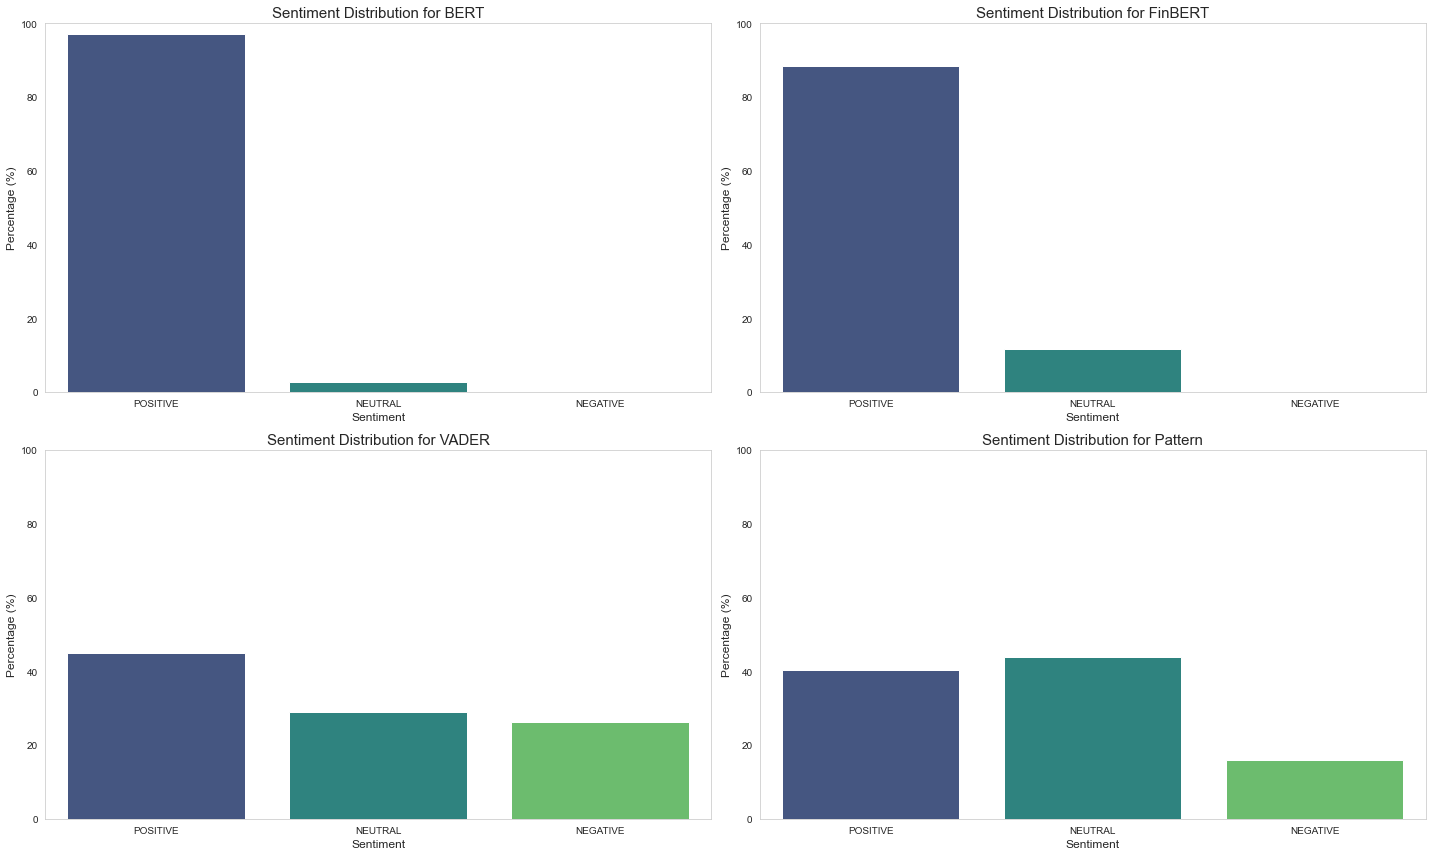

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentiment_distribution(dataframes, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(20,12))
    axes = axes.ravel()  # Flatten the axes array for easier indexing
    
    for idx, (dataframe, model_name) in enumerate(zip(dataframes, model_names)):
        # Count the sentiment labels
        sentiment_counts = dataframe['sentiment_label'].value_counts(normalize=True) * 100
        
        # Order the sentiment labels
        order = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=order, palette="viridis", ax=axes[idx])
        
        # Set the title, labels, and other aesthetics
        axes[idx].set_title(f'Sentiment Distribution for {model_name}', fontsize=15)
        axes[idx].set_xlabel('Sentiment', fontsize=12)
        axes[idx].set_ylabel('Percentage (%)', fontsize=12)
        axes[idx].set_ylim(0, 100)
        axes[idx].grid(axis='y')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Plot sentiment distribution for each dataset
plot_sentiment_distribution(
    [socialmedia_dt_copy1, socialmedia_dt_copy2, socialmedia_dt_copy3, socialmedia_dt_copy4], 
    ["BERT", "FinBERT", "VADER", "Pattern"]
)


In [79]:
min_score = socialmedia_dt_copy1['sentiment_score'].min()
max_score = socialmedia_dt_copy1['sentiment_score'].max()

print(f"Minimum sentiment score for BERT: {min_score}")
print(f"Maximum sentiment score for BERT: {max_score}")

Minimum sentiment score for BERT: 0.5000573992729187
Maximum sentiment score for BERT: 0.999885082244873


In [80]:
min_score = socialmedia_dt_copy2['sentiment_score'].min()
max_score = socialmedia_dt_copy2['sentiment_score'].max()

print(f"Minimum sentiment score for FinBERT: {min_score}")
print(f"Maximum sentiment score for FinBERT: {max_score}")

Minimum sentiment score for FinBERT: 0.3356887102127075
Maximum sentiment score for FinBERT: 0.9759973287582397


In [88]:
# checking for class counts 
sentiment_counts = socialmedia_dt_copy1['sentiment_label'].value_counts()

print(sentiment_counts)

POSITIVE    142068
NEUTRAL       4163
Name: sentiment_label, dtype: int64


In [89]:
# checking for class counts 
sentiment_counts = socialmedia_dt_copy2['sentiment_label'].value_counts()

print(sentiment_counts)

POSITIVE    129160
NEUTRAL      17071
Name: sentiment_label, dtype: int64


In [90]:
# checking for class counts 
sentiment_counts = socialmedia_dt_copy3['sentiment_label'].value_counts()

print(sentiment_counts)

POSITIVE    65573
NEUTRAL     42297
NEGATIVE    38361
Name: sentiment_label, dtype: int64


In [91]:
# checking for class counts 
sentiment_counts = socialmedia_dt_copy4['sentiment_label'].value_counts()

print(sentiment_counts)

NEUTRAL     63996
POSITIVE    59056
NEGATIVE    23179
Name: sentiment_label, dtype: int64


# Score Aggregation

In [93]:
# Group by 'ticker_symbol' and date (assuming there's a 'date' column) and count occurrences of each combination
grouped = socialmedia_dt_copy1.groupby(['ticker_symbol', 'day_date']).size().reset_index(name='count')

# Filter out the combinations where the count is greater than 1 (indicating repeated days)
repeated_days = grouped[grouped['count'] > 1]

print(repeated_days)


     ticker_symbol   day_date  count
0             AAPL 2015-01-01      8
1             AAPL 2015-01-02      6
3             AAPL 2015-01-04      4
4             AAPL 2015-01-05      9
5             AAPL 2015-01-06      6
...            ...        ...    ...
9610          TSLA 2019-12-27    168
9611          TSLA 2019-12-28     76
9612          TSLA 2019-12-29    116
9613          TSLA 2019-12-30    236
9614          TSLA 2019-12-31    126

[8035 rows x 3 columns]


In [95]:
# Assuming you've already run the code to get repeated_days dataframe
table_to_display = repeated_days.sort_values(by=['count'], ascending=False)
print(table_to_display)

     ticker_symbol   day_date  count
9103          TSLA 2018-08-07    561
9343          TSLA 2019-04-04    485
9363          TSLA 2019-04-24    437
9545          TSLA 2019-10-23    428
9097          TSLA 2018-08-01    425
...            ...        ...    ...
6780          MSFT 2016-05-05      2
6785          MSFT 2016-05-12      2
6786          MSFT 2016-05-16      2
6787          MSFT 2016-05-17      2
6680          MSFT 2015-12-18      2

[8035 rows x 3 columns]


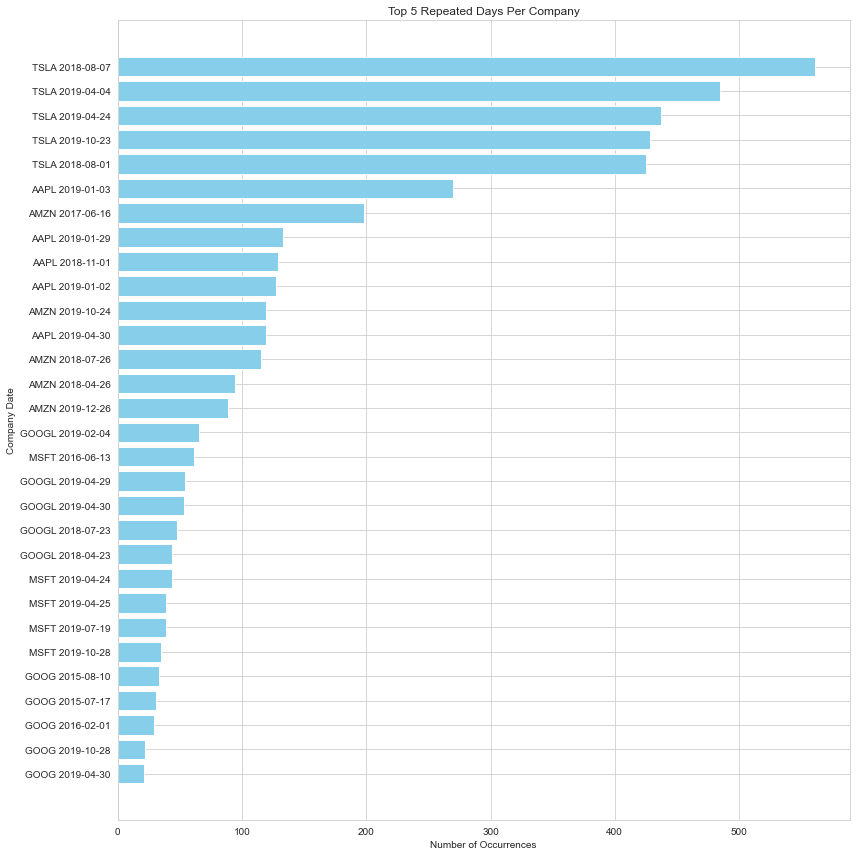

In [99]:
# Group by both ticker_symbol and date
grouped_counts = socialmedia_dt_copy1.groupby(['ticker_symbol', 'day_date']).size().reset_index(name='count')

# Sort by count for each company and take the top N dates
N = 5  # You can adjust this number based on your preference
top_dates_per_company = grouped_counts.groupby('ticker_symbol').apply(lambda x: x.nlargest(N, 'count')).reset_index(drop=True)

# Sort for better visualization
top_dates_sorted = top_dates_per_company.sort_values(by=['count'], ascending=True)

# Plotting
plt.figure(figsize=(12, 12))
plt.barh(top_dates_sorted['ticker_symbol'] + " " + top_dates_sorted['day_date'].astype(str), 
         top_dates_sorted['count'], color='skyblue')
plt.xlabel('Number of Occurrences')
plt.ylabel('Company Date')
plt.title(f'Top {N} Repeated Days Per Company')
plt.tight_layout()
plt.show()


In [100]:
from scipy import stats

# Calculate the daily sentiment scores for each company
daily_sentiment_scores = socialmedia_dt_copy1.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].apply(list).reset_index()

# Calculate the skewness for each company
for company in daily_sentiment_scores['ticker_symbol'].unique():
    company_scores = daily_sentiment_scores[daily_sentiment_scores['ticker_symbol'] == company]['sentiment_score']
    # Flatten the list of scores
    company_scores = [score for sublist in company_scores for score in sublist]
    skewness = stats.skew(company_scores)
    print(f'Skewness for {company}: {skewness}')

Skewness for AAPL: -3.155367360338631
Skewness for AMZN: -3.3306179196861487
Skewness for GOOG: -4.664832650112787
Skewness for GOOGL: -4.118615651608931
Skewness for MSFT: -3.436138820080577
Skewness for TSLA: -3.27981947191057


In [22]:
from scipy import stats

# Add a count column to the DataFrame
socialmedia_dt_copy1['count'] = socialmedia_dt_copy1.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].transform('count')

# Filter for overlapping days
overlapping_days = socialmedia_dt_copy1[socialmedia_dt_copy1['count'] > 1]

# Calculate skewness for each day for each company
skewness_df = overlapping_days.groupby(['ticker_symbol', 'day_date']).apply(lambda x: stats.skew(x['sentiment_score'])).reset_index()
skewness_df.columns = ['ticker_symbol', 'day_date', 'skewness']

# Print the skewness
print(skewness_df)

     ticker_symbol   day_date  skewness
0             AAPL 2015-01-01  0.106725
1             AAPL 2015-01-02 -0.165771
2             AAPL 2015-01-04  0.290960
3             AAPL 2015-01-05 -1.320965
4             AAPL 2015-01-06 -1.785831
...            ...        ...       ...
8030          TSLA 2019-12-27 -2.683154
8031          TSLA 2019-12-28 -2.266979
8032          TSLA 2019-12-29 -3.942995
8033          TSLA 2019-12-30 -4.151048
8034          TSLA 2019-12-31 -3.120201

[8035 rows x 3 columns]


In [23]:
def categorize_skewness(skewness):
    if skewness < -1 or skewness > 1:
        return 'highly skewed'
    elif -1 <= skewness < -0.5 or 0.5 <= skewness < 1:
        return 'moderately skewed'
    else:
        return 'approximately symmetric'

skewness_df['category'] = skewness_df['skewness'].apply(categorize_skewness)

category_counts = skewness_df['category'].value_counts()
print(category_counts)


highly skewed              4251
approximately symmetric    2286
moderately skewed          1498
Name: category, dtype: int64


In [101]:
# Step 1: We calculate the day of the week (0 = Monday, 6 = Sunday)
socialmedia_dt_copy1['day_of_week'] = socialmedia_dt_copy1['day_date'].dt.dayofweek

# Step 2: We hift the sentiment scores of Saturday and Sunday to the following Monday
socialmedia_dt_copy1.loc[socialmedia_dt_copy1['day_of_week'] == 5, 'day_date'] += pd.DateOffset(days=2)
socialmedia_dt_copy1.loc[socialmedia_dt_copy1['day_of_week'] == 6, 'day_date'] += pd.DateOffset(days=1)

# Step 3: We calculate the median daily sentiment score per each company, including the shifted weekend scores
final_daily_sentiment = socialmedia_dt_copy1.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].median().reset_index()

# Check the final dataframe
final_daily_sentiment

,ticker_symbol,day_date,sentiment_score
0,AAPL,2015-01-01,0.983825
1,AAPL,2015-01-02,0.983870
2,AAPL,2015-01-05,0.989056
3,AAPL,2015-01-06,0.995351
4,AAPL,2015-01-07,0.983648
...,...,...,...
7200,TSLA,2019-12-25,0.985944
7201,TSLA,2019-12-26,0.992521
7202,TSLA,2019-12-27,0.989841
7203,TSLA,2019-12-30,0.995553


In [102]:
# Step 1: We calculate the day of the week (0 = Monday, 6 = Sunday)
socialmedia_dt_copy2['day_of_week'] = socialmedia_dt_copy2['day_date'].dt.dayofweek

# Step 2: We hift the sentiment scores of Saturday and Sunday to the following Monday
socialmedia_dt_copy2.loc[socialmedia_dt_copy2['day_of_week'] == 5, 'day_date'] += pd.DateOffset(days=2)
socialmedia_dt_copy2.loc[socialmedia_dt_copy2['day_of_week'] == 6, 'day_date'] += pd.DateOffset(days=1)

# Step 3: We calculate the median daily sentiment score per each company, including the shifted weekend scores
final_daily_sentiment2 = socialmedia_dt_copy2.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].median().reset_index()

# Check the final dataframe
final_daily_sentiment2

,ticker_symbol,day_date,sentiment_score
0,AAPL,2015-01-01,0.906014
1,AAPL,2015-01-02,0.895460
2,AAPL,2015-01-05,0.900710
3,AAPL,2015-01-06,0.839730
4,AAPL,2015-01-07,0.731754
...,...,...,...
7200,TSLA,2019-12-25,0.891846
7201,TSLA,2019-12-26,0.881315
7202,TSLA,2019-12-27,0.877670
7203,TSLA,2019-12-30,0.883057


In [103]:
# Step 1: We calculate the day of the week (0 = Monday, 6 = Sunday)
socialmedia_dt_copy3['day_of_week'] = socialmedia_dt_copy3['day_date'].dt.dayofweek

# Step 2: We hift the sentiment scores of Saturday and Sunday to the following Monday
socialmedia_dt_copy3.loc[socialmedia_dt_copy3['day_of_week'] == 5, 'day_date'] += pd.DateOffset(days=2)
socialmedia_dt_copy3.loc[socialmedia_dt_copy3['day_of_week'] == 6, 'day_date'] += pd.DateOffset(days=1)

# Step 3: We calculate the median daily sentiment score per each company, including the shifted weekend scores
final_daily_sentiment3 = socialmedia_dt_copy3.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].median().reset_index()

# Check the final dataframe
final_daily_sentiment3

,ticker_symbol,day_date,sentiment_score
0,AAPL,2015-01-01,0.20230
1,AAPL,2015-01-02,0.10115
2,AAPL,2015-01-05,0.20230
3,AAPL,2015-01-06,-0.01290
4,AAPL,2015-01-07,0.21430
...,...,...,...
7200,TSLA,2019-12-25,0.27320
7201,TSLA,2019-12-26,0.00000
7202,TSLA,2019-12-27,0.00000
7203,TSLA,2019-12-30,0.00000


In [104]:
# Step 1: We calculate the day of the week (0 = Monday, 6 = Sunday)
socialmedia_dt_copy4['day_of_week'] = socialmedia_dt_copy4['day_date'].dt.dayofweek

# Step 2: We hift the sentiment scores of Saturday and Sunday to the following Monday
socialmedia_dt_copy4.loc[socialmedia_dt_copy4['day_of_week'] == 5, 'day_date'] += pd.DateOffset(days=2)
socialmedia_dt_copy4.loc[socialmedia_dt_copy4['day_of_week'] == 6, 'day_date'] += pd.DateOffset(days=1)

# Step 3: We calculate the median daily sentiment score per each company, including the shifted weekend scores
final_daily_sentiment4 = socialmedia_dt_copy4.groupby(['ticker_symbol', 'day_date'])['sentiment_score'].median().reset_index()

# Check the final dataframe
final_daily_sentiment4

,ticker_symbol,day_date,sentiment_score
0,AAPL,2015-01-01,0.068182
1,AAPL,2015-01-02,0.312500
2,AAPL,2015-01-05,0.078869
3,AAPL,2015-01-06,0.000000
4,AAPL,2015-01-07,0.068182
...,...,...,...
7200,TSLA,2019-12-25,0.066667
7201,TSLA,2019-12-26,0.000000
7202,TSLA,2019-12-27,0.000000
7203,TSLA,2019-12-30,0.000000


# Company Market Values and Volatility Calculation

In [106]:
# Create a DataFrame with all weekdays in the given date range
all_weekdays2 = pd.date_range(start='2015-01-01', end='2019-12-31', freq=pd.offsets.BDay())

# Initialize a dictionary to hold the results
missing_dates_count2 = {}

# Loop over all companies
for company in final_daily_sentiment['ticker_symbol'].unique():
    # Filter the DataFrame for the current company
    company_df2 = final_daily_sentiment[final_daily_sentiment['ticker_symbol'] == company]
    
    # Find the missing dates by checking if all_weekdays are in the company's 'day_date'
    company_missing_dates2 = all_weekdays2[~all_weekdays2.isin(company_df2['day_date'])]
    
    # Add the count of missing dates for the current company to the results dictionary
    missing_dates_count2[company] = len(company_missing_dates2)

# Convert the dictionary to a DataFrame
missing_dates_count_df2 = pd.DataFrame(list(missing_dates_count2.items()), columns=['ticker_symbol', 'missing_dates_count2'])

# Print the count of missing dates for each company
print(missing_dates_count_df2)

  ticker_symbol  missing_dates_count2
0          AAPL                    13
1          AMZN                    57
2          GOOG                   183
3         GOOGL                   113
4          MSFT                   180
5          TSLA                    73


In [107]:
# Initialize a dictionary to hold the total days for each company
total_days_count = {}

# Loop over all companies
for company in final_daily_sentiment['ticker_symbol'].unique():
    # Filter the DataFrame for the current company
    company_df2 = final_daily_sentiment[final_daily_sentiment['ticker_symbol'] == company]
    
    # Count the total days for the current company
    total_days_count[company] = len(company_df2)

# Convert the dictionary to a DataFrame
total_days_count_df = pd.DataFrame(list(total_days_count.items()), columns=['ticker_symbol', 'total_days_count'])

# Merge the two DataFrames
missing_dates_percent_df = pd.merge(missing_dates_count_df2, total_days_count_df, on='ticker_symbol')

# Calculate the percentage of missing dates
missing_dates_percent_df['missing_dates_percent'] = missing_dates_percent_df['missing_dates_count2'] / missing_dates_percent_df['total_days_count'] * 100

# Print the percentage of missing dates for each company
missing_dates_percent_df

,ticker_symbol,missing_dates_count2,total_days_count,missing_dates_percent
0,AAPL,13,1291,1.006971
1,AMZN,57,1247,4.570970
2,GOOG,183,1121,16.324710
3,GOOGL,113,1191,9.487825
4,MSFT,180,1124,16.014235
5,TSLA,73,1231,5.930138


In [108]:
company_value

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.4700
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.6300
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.0900
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.5000
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.3500
...,...,...,...,...,...,...,...
17523,TSLA,2019-12-21,405.59,14785210,410.29,413.00,400.1850
17524,TSLA,2019-12-22,405.59,14785210,410.29,413.00,400.1850
17525,TSLA,2019-12-25,425.25,8054720,418.36,425.47,412.6875
17526,TSLA,2019-12-28,430.38,9956827,435.00,435.31,426.1100


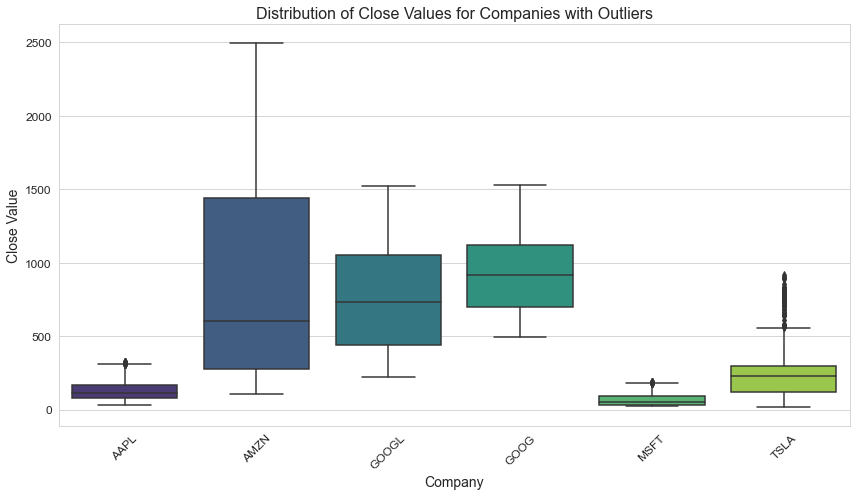

In [39]:
#Constructing the plot settings
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the boxplot
box_plot = sns.boxplot(x="ticker_symbol", y="close_value", data=company_value, palette="viridis")

# Title and labels
plt.title("Distribution of Close Values for Companies with Outliers", fontsize=16)
plt.xlabel("Company", fontsize=14)
plt.ylabel("Close Value", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [109]:
company_value['day_date']  = pd.to_datetime(company_value['day_date'])

In [110]:
def calculate_volatility(df, window=1):
    # Calculate daily returns
    df["returns"] = df.groupby("ticker_symbol")["close_value"].pct_change()
    
    # Calculate rolling standard deviation of daily returns (volatility)
    df["volatility"] = (
        df.groupby("ticker_symbol")["returns"]
        .rolling(window)
        .std()
        .reset_index(level=0, drop=True)  
        * np.sqrt(window)
    )
    return df
# Calculate daily volatility with a 5-day window
company_value = calculate_volatility(company_value, window=5)

In [111]:
company_value = company_value.dropna(subset=['volatility'])

In [112]:
# Use the isna() function to check for NaN values in the 'returns' and 'volatility' columns, and sum() to count them
num_nan_returns = company_value['returns'].isna().sum()
num_nan_volatility = company_value['volatility'].isna().sum()

num_nan_returns, num_nan_volatility

(0, 0)

In [113]:
company_value

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns,volatility
5,AAPL,2020-05-21,316.85,25672210,318.66,320.89,315.8700,-0.006397,0.011462
6,AAPL,2020-05-20,319.23,27876220,316.68,319.52,316.2000,0.007511,0.014181
7,AAPL,2020-05-19,313.14,25432390,315.03,318.52,313.0100,-0.019077,0.024461
8,AAPL,2020-05-18,314.96,33843130,313.17,316.50,310.3241,0.005812,0.025882
9,AAPL,2020-05-15,307.71,41587090,300.35,307.90,300.2100,-0.023019,0.031176
...,...,...,...,...,...,...,...,...,...
17523,TSLA,2019-12-21,405.59,14785210,410.29,413.00,400.1850,0.131700,0.126312
17524,TSLA,2019-12-22,405.59,14785210,410.29,413.00,400.1850,0.000000,0.131989
17525,TSLA,2019-12-25,425.25,8054720,418.36,425.47,412.6875,0.048473,0.122291
17526,TSLA,2019-12-28,430.38,9956827,435.00,435.31,426.1100,0.012063,0.124745


# Merging of Datasets

In [135]:
merged_df = company_value.merge(final_daily_sentiment, on=['ticker_symbol', 'day_date'])

In [136]:
merged_df2 = company_value.merge(final_daily_sentiment2, on=['ticker_symbol', 'day_date'])

In [137]:
merged_df3 = company_value.merge(final_daily_sentiment3, on=['ticker_symbol', 'day_date'])

In [170]:
merged_df4 = company_value.merge(final_daily_sentiment4, on=['ticker_symbol', 'day_date'])

# Statistical Significance for all sentiment analysis models

           BERT   FinBERT     VADER   Pattern
AAPL   0.912058  0.222363  0.451497  0.656139
AMZN   0.425793  0.243598  0.022116  0.000007
GOOGL  0.379730  0.414078  0.538651  0.685512
GOOG   0.841149  0.122861  0.337562  0.081545
MSFT   0.823122  0.928149  0.605723  0.189821
TSLA   0.642880  0.746499  0.033838  0.567518


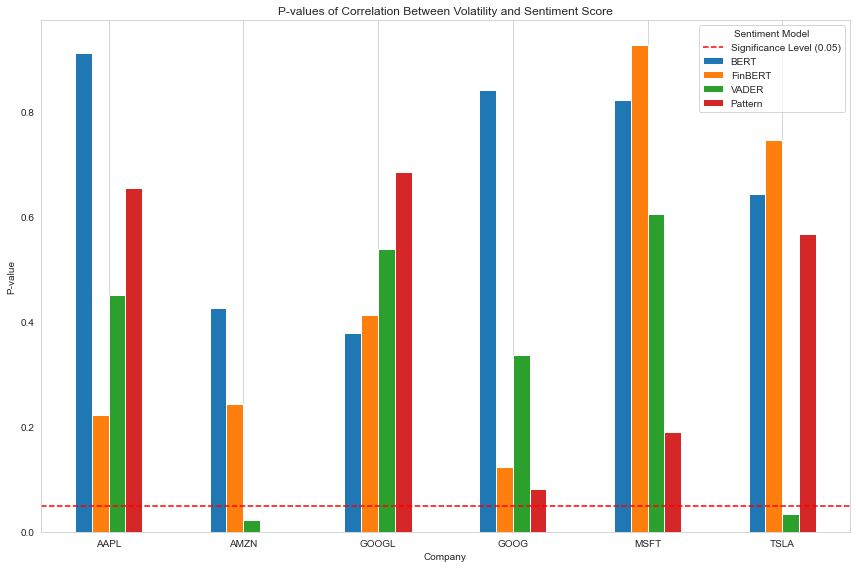

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to display the p-values in a table format
data = {
    "BERT": p_values_bert,
    "FinBERT": p_values_finbert,
    "VADER": p_values_vader,
    "Pattern": p_values_pattern
}
df_p_values = pd.DataFrame(data)

# Display the table
print(df_p_values)

# Plot the p-values using a bar plot
df_p_values.plot(kind="bar", figsize=(12, 8), rot=0)
plt.title('P-values of Correlation Between Volatility and Sentiment Score')
plt.ylabel('P-value')
plt.xlabel('Company')
plt.legend(title='Sentiment Model')
plt.tight_layout()
plt.grid(axis='y')
plt.axhline(y=0.05, color='r', linestyle='--', label="Significance Level (0.05)")
plt.legend(title='Sentiment Model', loc='upper right')
plt.show()

           BERT   FinBERT     VADER   Pattern
AAPL   0.463189  0.464737  0.761007  0.721417
AMZN   0.338959  0.779994  0.360988  0.444854
GOOGL  0.010317  0.967235  0.062000  0.355255
GOOG   0.511016  0.020619  0.037965  0.053833
MSFT   0.403937  0.005062  0.900049  0.709041
TSLA   0.523997  0.928578  0.561723  0.450033


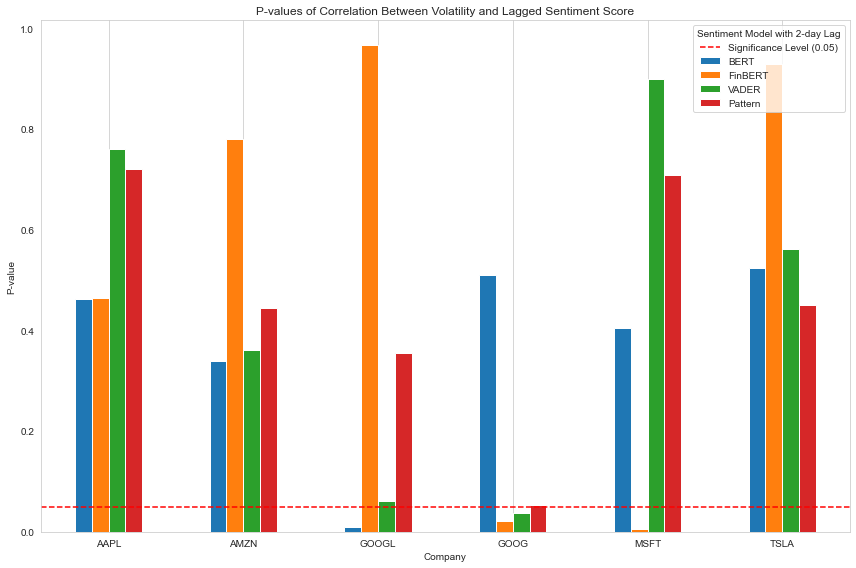

In [120]:
def calculate_p_values_with_lag(df, lag=2):
    # Create a lagged sentiment score column
    df['lagged_sentiment'] = df.groupby('ticker_symbol')['sentiment_score'].shift(lag)
    
    companies = df['ticker_symbol'].unique()
    p_values = {}

    for company in companies:
        company_data = df[df['ticker_symbol'] == company].dropna()  # drop any rows with NaN values due to the lag
        correlation, p_value = pearsonr(company_data['lagged_sentiment'], company_data['volatility'])
        p_values[company] = p_value

    return p_values

# Calculate p-values with a 2-day lag for each model
p_values_bert_lagged = calculate_p_values_with_lag(merged_df)
p_values_finbert_lagged = calculate_p_values_with_lag(merged_df2)
p_values_vader_lagged = calculate_p_values_with_lag(merged_df3)
p_values_pattern_lagged = calculate_p_values_with_lag(merged_df4)

# Create a DataFrame for visualization
data_lagged = {
    "BERT": p_values_bert_lagged,
    "FinBERT": p_values_finbert_lagged,
    "VADER": p_values_vader_lagged,
    "Pattern": p_values_pattern_lagged
}
df_p_values_lagged = pd.DataFrame(data_lagged)

# Display the table
print(df_p_values_lagged)

# Plot the p-values using a bar plot
df_p_values_lagged.plot(kind="bar", figsize=(12, 8), rot=0)
plt.title('P-values of Correlation Between Volatility and Lagged Sentiment Score')
plt.ylabel('P-value')
plt.xlabel('Company')
plt.legend(title='Sentiment Model with 2-day Lag')
plt.tight_layout()
plt.grid(axis='y')
plt.axhline(y=0.05, color='r', linestyle='--', label="Significance Level (0.05)")
plt.legend(title='Sentiment Model with 2-day Lag', loc='upper right')
plt.show()

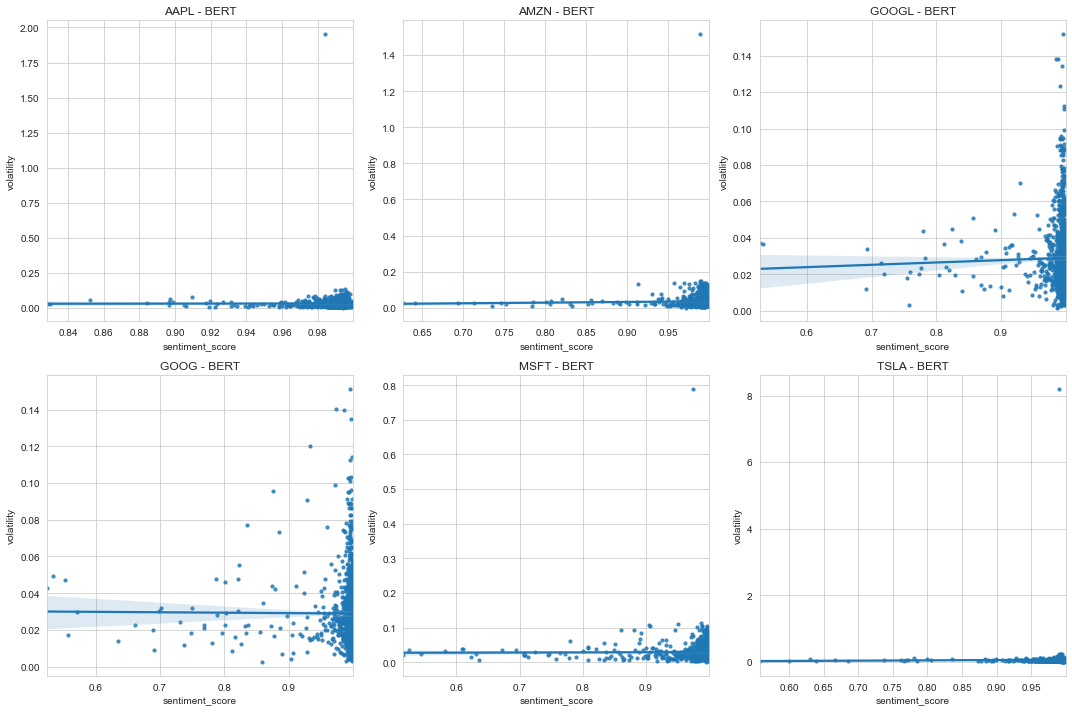

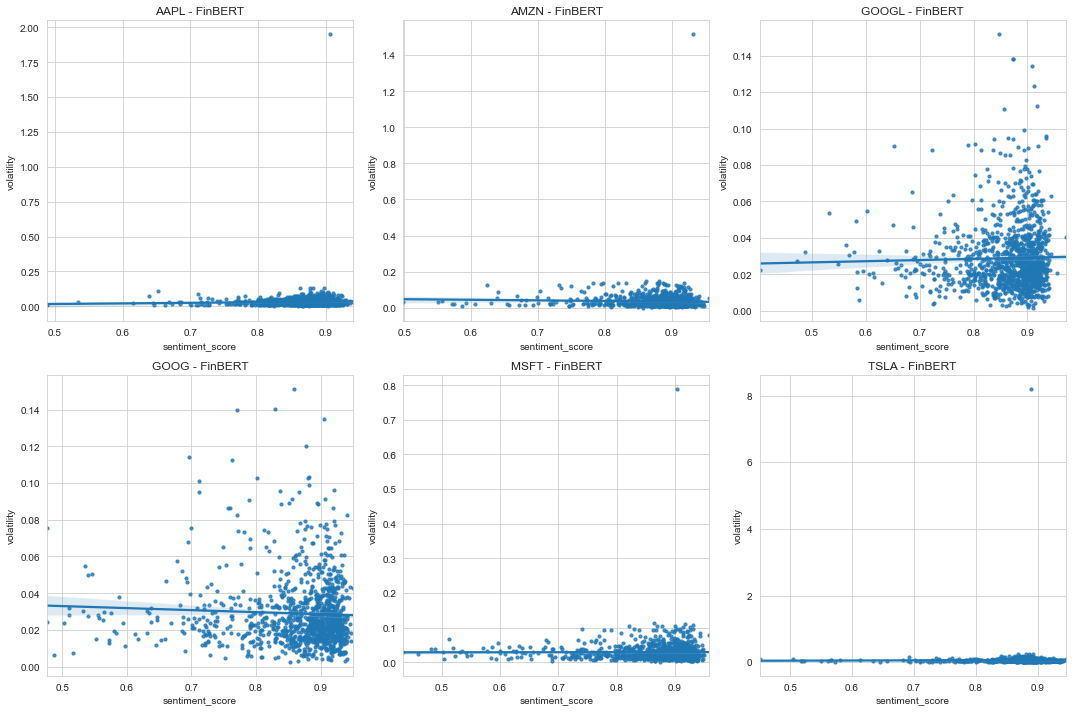

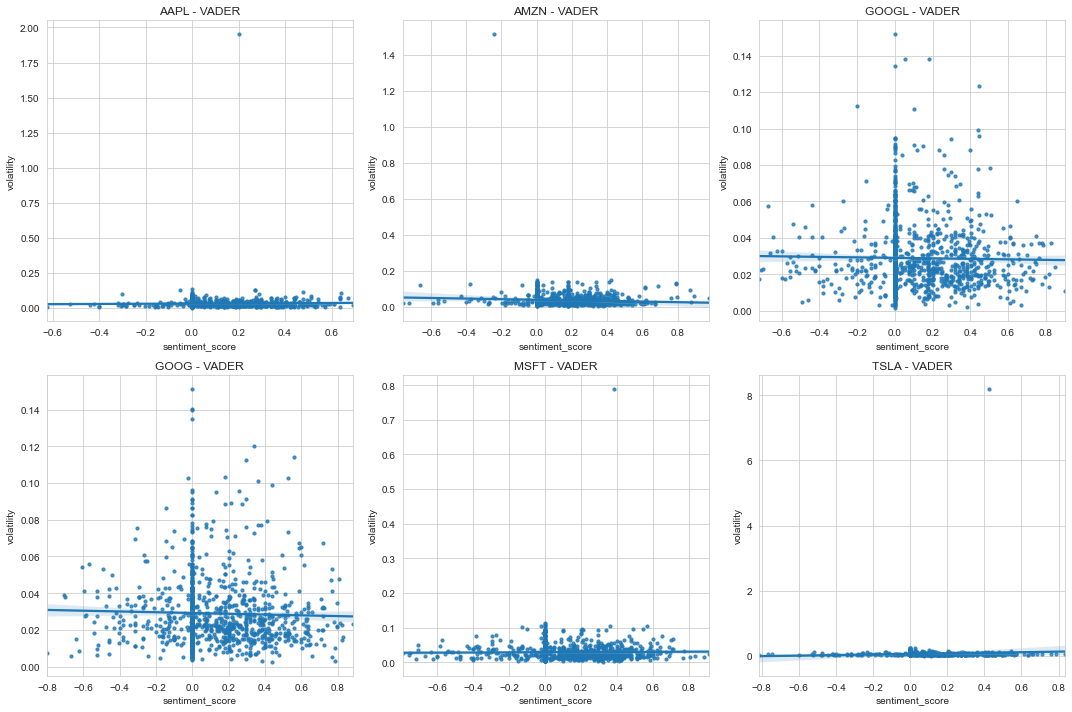

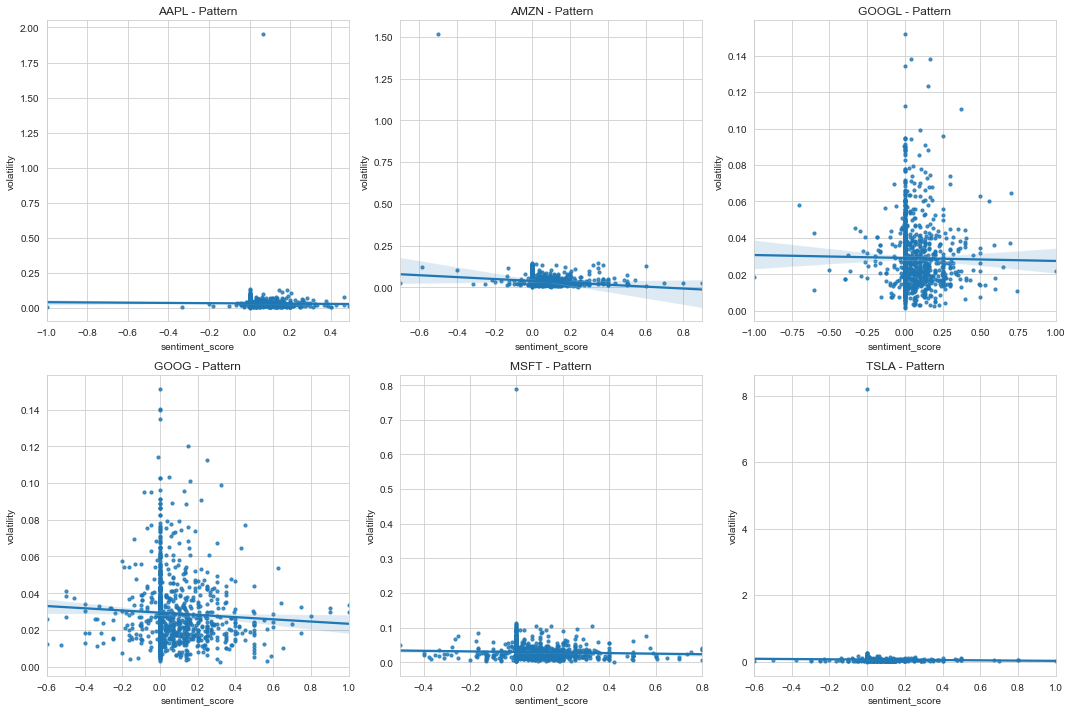

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_regression(df, title):
    companies = df['ticker_symbol'].unique()
    plt.figure(figsize=(15, 10))
    
    for i, company in enumerate(companies, 1):
        plt.subplot(2, 3, i)  # Assuming 6 companies
        sns.regplot(x='sentiment_score', y='volatility', data=df[df['ticker_symbol'] == company], scatter_kws={'s':10})
        plt.title(f'{company} - {title}')
        plt.tight_layout()

# Plot regression plots for each model
plot_regression(merged_df, "BERT")
plot_regression(merged_df2, "FinBERT")
plot_regression(merged_df3, "VADER")
plot_regression(merged_df4, "Pattern")

plt.show()

In [122]:
import pandas as pd
from scipy.stats import linregress

def analyze_relationship(df):
    companies = df['ticker_symbol'].unique()
    results = []

    for company in companies:
        subset = df[df['ticker_symbol'] == company]
        slope, intercept, r_value, p_value, std_err = linregress(subset['sentiment_score'], subset['volatility'])
        results.append((company, r_value, p_value))

    return pd.DataFrame(results, columns=['Company', 'Correlation Coefficient', 'P-value'])

# Analyze the relationship for each model
bert_results = analyze_relationship(merged_df)
finbert_results = analyze_relationship(merged_df2)
vader_results = analyze_relationship(merged_df3)
pattern_results = analyze_relationship(merged_df4)

# Combine results into one table
combined_results = pd.concat([bert_results, finbert_results, vader_results, pattern_results], 
                             keys=['BERT', 'FinBERT', 'VADER', 'Pattern'], axis=1)

combined_results

BERT                                   FinBERT                          \
  Company Correlation Coefficient   P-value Company Correlation Coefficient   
0    AAPL                0.003077  0.912058    AAPL                0.033985   
1    AMZN                0.022573  0.425793    AMZN               -0.033044   
2   GOOGL                0.025475  0.379730   GOOGL                0.023688   
3    GOOG               -0.005993  0.841149    GOOG               -0.046109   
4    MSFT                0.006675  0.823122    MSFT                0.002693   
5    TSLA                0.013228  0.642880    TSLA                0.009223   

              VADER                                   Pattern  \
    P-value Company Correlation Coefficient   P-value Company   
0  0.222363    AAPL                0.020973  0.451497    AAPL   
1  0.243598    AMZN               -0.064799  0.022116    AMZN   
2  0.414078   GOOGL               -0.017834  0.538651   GOOGL   
3  0.122861    GOOG               -0.028669  0.337562    GOOG   
4  0.928149    MSFT                0.015413  0.605723    MSFT   
5  0.746499    TSLA                0.060487  0.033838    TSLA   

                                     
  Correlation Coefficient   P-value  
0               -0.012404  0.656139  
1               -0.127042  0.000007  
2               -0.011746  0.685512  
3               -0.052046  0.081545  
4               -0.039136  0.189821  
5               -0.016310  0.567518

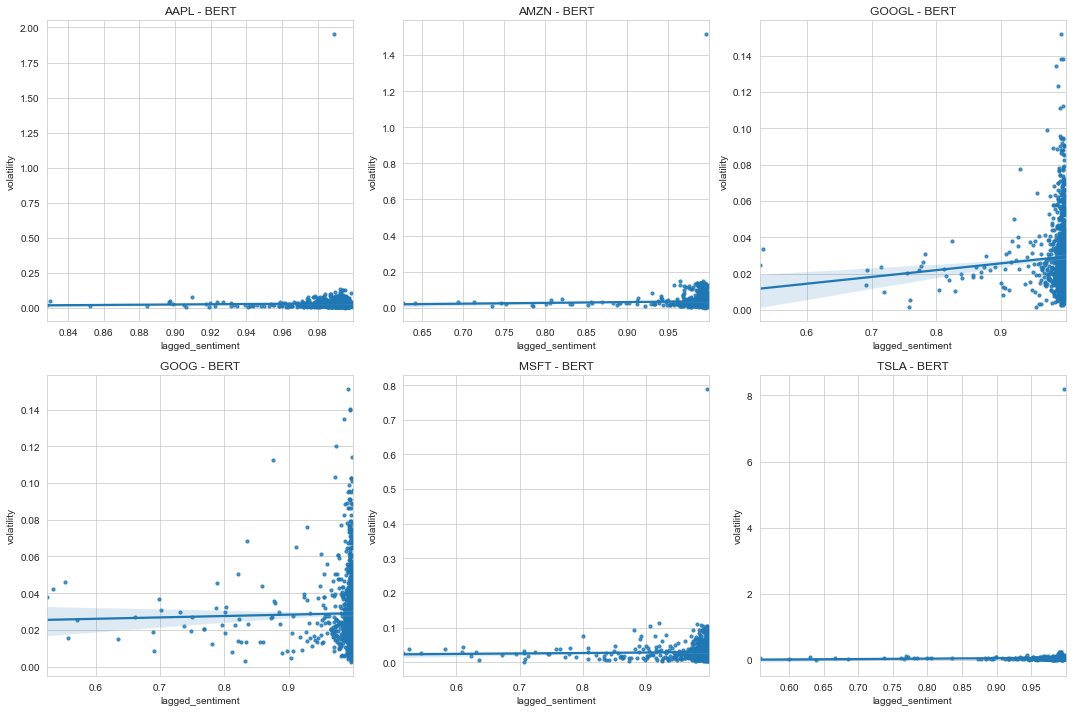

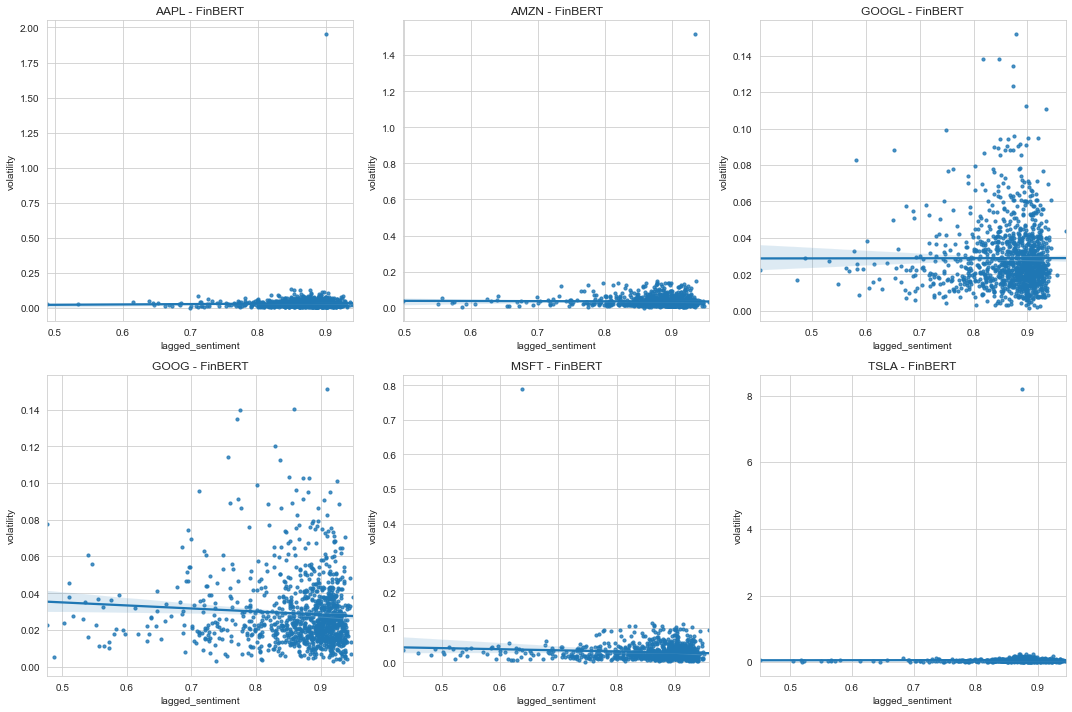

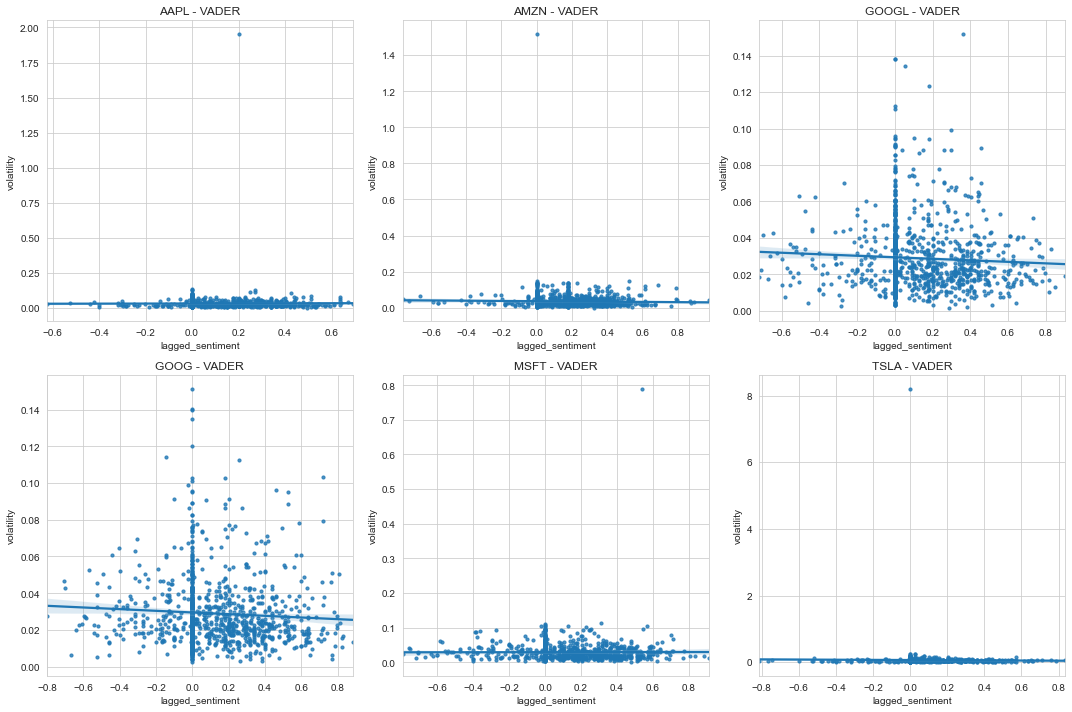

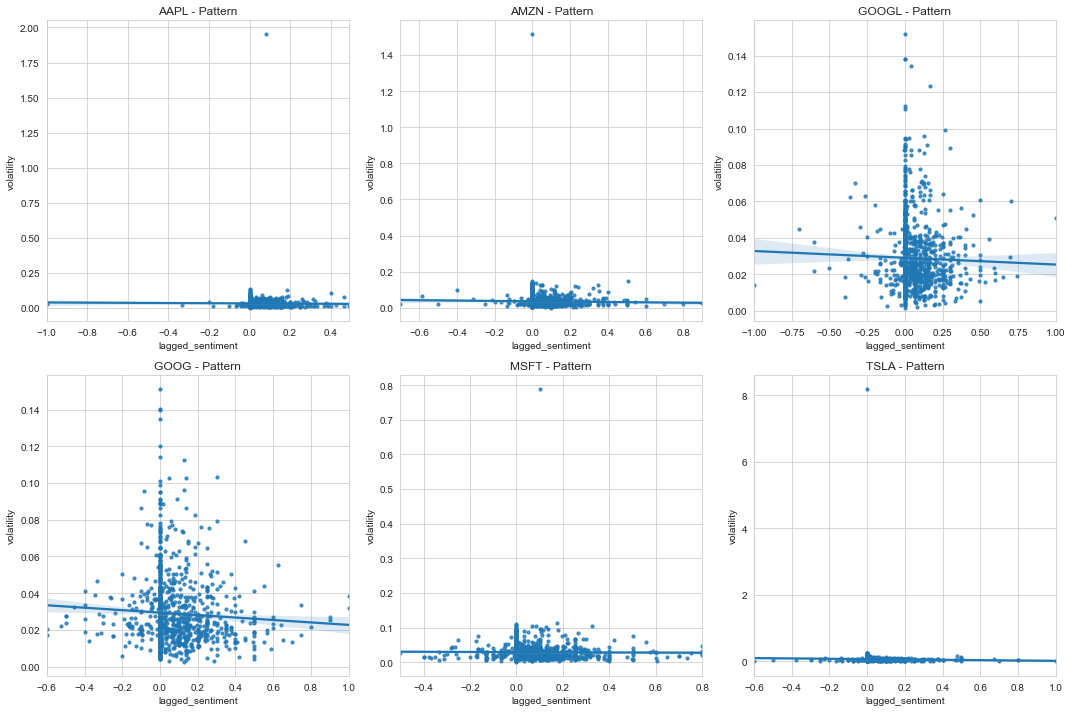

In [124]:
def plot_lagged_regression(df, title, lag_days=2):
    companies = df['ticker_symbol'].unique()
    plt.figure(figsize=(15, 10))
    
    for i, company in enumerate(companies, 1):
        temp_df = df[df['ticker_symbol'] == company].copy()
        temp_df['lagged_sentiment'] = temp_df['sentiment_score'].shift(lag_days)
        
        plt.subplot(2, 3, i)  # Assuming 6 companies
        sns.regplot(x='lagged_sentiment', y='volatility', data=temp_df, scatter_kws={'s':10})
        plt.title(f'{company} - {title}')
        plt.tight_layout()

# Plot regression plots for each model with 2-day lag
plot_lagged_regression(merged_df, "BERT")
plot_lagged_regression(merged_df2, "FinBERT")
plot_lagged_regression(merged_df3, "VADER")
plot_lagged_regression(merged_df4, "Pattern")

plt.show()

In [126]:
def analyze_relationship_with_lag(df, lag=2):
    # Create a copy of the dataframe to ensure the original data is not altered
    df_copy = df.copy()
    
    # Introduce a lag for the sentiment scores
    df_copy['lagged_sentiment'] = df_copy.groupby('ticker_symbol')['sentiment_score'].shift(lag)
    
    # Drop rows with NaN due to the lag
    df_copy.dropna(subset=['lagged_sentiment'], inplace=True)
    
    companies = df_copy['ticker_symbol'].unique()
    results = []

    for company in companies:
        subset = df_copy[df_copy['ticker_symbol'] == company]
        slope, intercept, r_value, p_value, std_err = linregress(subset['lagged_sentiment'], subset['volatility'])
        results.append((company, r_value, p_value))

    return pd.DataFrame(results, columns=['Company', 'Correlation Coefficient', 'P-value'])

# Analyze the relationship for each model with a 2-day lag
bert_results_lagged = analyze_relationship_with_lag(merged_df, lag=2)
finbert_results_lagged = analyze_relationship_with_lag(merged_df2, lag=2)
vader_results_lagged = analyze_relationship_with_lag(merged_df3, lag=2)
pattern_results_lagged = analyze_relationship_with_lag(merged_df4, lag=2)

# Combine results into one table
combined_results_lagged = pd.concat([bert_results_lagged, finbert_results_lagged, vader_results_lagged, pattern_results_lagged], 
                                    keys=['BERT', 'FinBERT', 'VADER', 'Pattern'], axis=1)

combined_results_lagged

BERT                                   FinBERT                          \
  Company Correlation Coefficient   P-value Company Correlation Coefficient   
0    AAPL                0.020451  0.463189    AAPL                0.020380   
1    AMZN                0.027123  0.338959    AMZN               -0.007924   
2   GOOGL                0.074362  0.010317   GOOGL                0.001192   
3    GOOG                0.019668  0.511016    GOOG               -0.069196   
4    MSFT                0.024940  0.403937    MSFT               -0.083629   
5    TSLA                0.018193  0.523997    TSLA                0.002559   

              VADER                                   Pattern  \
    P-value Company Correlation Coefficient   P-value Company   
0  0.464737    AAPL                0.008480  0.761007    AAPL   
1  0.779994    AMZN               -0.025911  0.360988    AMZN   
2  0.967235   GOOGL               -0.054141  0.062000   GOOGL   
3  0.020619    GOOG               -0.062047  0.037965    GOOG   
4  0.005062    MSFT                0.003754  0.900049    MSFT   
5  0.928578    TSLA               -0.016568  0.561723    TSLA   

                                     
  Correlation Coefficient   P-value  
0               -0.009941  0.721417  
1               -0.021672  0.444854  
2               -0.026833  0.355255  
3               -0.057658  0.053833  
4               -0.011152  0.709041  
5               -0.021566  0.450033

In [139]:
merged_df

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns,volatility,sentiment_score
0,AAPL,2019-12-31,293.65,25247630,289.93,293.68,289.5200,-0.022307,0.030228,0.992244
1,AAPL,2019-12-30,291.52,36059610,289.46,292.69,285.2200,-0.007254,0.027981,0.989373
2,AAPL,2019-12-27,289.80,36592940,291.12,293.97,288.1200,-0.005900,0.025466,0.992516
3,AAPL,2019-12-26,289.91,23334000,284.82,289.98,284.7000,0.000380,0.026313,0.990052
4,AAPL,2019-12-24,284.27,12119710,284.69,284.89,282.9197,-0.019454,0.021472,0.992919
...,...,...,...,...,...,...,...,...,...,...
7200,TSLA,2019-05-27,190.63,14136570,199.83,199.98,188.7505,0.000000,0.133206,0.992155
7201,TSLA,2019-07-04,234.90,14201150,239.39,241.57,234.5100,0.051195,0.050873,0.993401
7202,TSLA,2019-09-02,225.61,9327775,229.15,232.44,224.2130,0.000000,0.085621,0.990286
7203,TSLA,2019-11-28,331.29,5563459,331.12,333.93,328.5700,-0.005255,0.078428,0.991356


# LSTM Model Training

## BERT LSTM

In [133]:
# Training an LSTM using BERT as sentiment 

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Select numerical features
features = merged_df.select_dtypes(include=[np.number])

# We will predict 'volatility'
target = 'volatility'
features = features.drop(columns=[target])

# Scale the features
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

# Scale the target
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(merged_df[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# Split the data for each company separately
train_Xs = []
test_Xs = []
train_ys = []
test_ys = []
for company in merged_df['ticker_symbol'].unique():
    company_indices = merged_df[merged_df['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs.append(reshaped_features[train_indices])
    test_Xs.append(reshaped_features[test_indices])
    train_ys.append(scaled_target[train_indices])
    test_ys.append(scaled_target[test_indices])

train_X = np.concatenate(train_Xs)
test_X = np.concatenate(test_Xs)
train_y = np.concatenate(train_ys)
test_y = np.concatenate(test_ys)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_X, train_y, epochs=200, verbose=0)

# Make predictions
predictions = model.predict(test_X)

# Inverse scale the predictions
inv_predictions = scaler_target.inverse_transform(predictions)

# Print the inverse predictions
print(inv_predictions)

46/46 [==============================] - 0s 833us/step
[[0.03307481]
 [0.03573586]
 [0.03268475]
 ...
 [0.05208031]
 [0.05969491]
 [0.06509634]]


In [134]:
# Inverse scale the test set and predictions
inv_test_y = scaler_target.inverse_transform(test_y)
inv_predictions = scaler_target.inverse_transform(predictions)

# Compute Mean Squared Error
mse = mean_squared_error(inv_test_y, inv_predictions)
print('Mean Squared Error: ', mse)

# Compute Mean Absolute Error
mae = mean_absolute_error(inv_test_y, inv_predictions)
print('Mean Absolute Error: ', mae)

Mean Squared Error:  0.03932821247048313
Mean Absolute Error:  0.02642254771928847


## BERT LSTM with a 2-day lagging

In [144]:
# Introduce a 2-day lag for the sentiment score

merged_df_lagged = merged_df.copy()
merged_df_lagged['lagged_sentiment'] = merged_df_lagged.groupby('ticker_symbol')['sentiment_score'].shift(2)

# Drop rows with NaN due to the lag and reset the index
merged_df_lagged.dropna(subset=['lagged_sentiment'], inplace=True)
merged_df_lagged.reset_index(drop=True, inplace=True)

# Select numerical features
features_lagged = merged_df_lagged.select_dtypes(include=[np.number])

# We will predict 'volatility'
target = 'volatility'
features_lagged = features_lagged.drop(columns=[target])

# Scale the features
scaler_features_lagged = MinMaxScaler()
scaled_features_lagged = scaler_features_lagged.fit_transform(features_lagged)

# Scale the target
scaled_target_lagged = scaler_target.transform(merged_df_lagged[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features_lagged = scaled_features_lagged.reshape((scaled_features_lagged.shape[0], 1, scaled_features_lagged.shape[1]))

# Split the data for each company separately
train_Xs_lagged = []
test_Xs_lagged = []
train_ys_lagged = []
test_ys_lagged = []
for company in merged_df_lagged['ticker_symbol'].unique():
    company_indices = merged_df_lagged[merged_df_lagged['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs_lagged.append(reshaped_features_lagged[train_indices])
    test_Xs_lagged.append(reshaped_features_lagged[test_indices])
    train_ys_lagged.append(scaled_target_lagged[train_indices])
    test_ys_lagged.append(scaled_target_lagged[test_indices])

train_X_lagged = np.concatenate(train_Xs_lagged)
test_X_lagged = np.concatenate(test_Xs_lagged)
train_y_lagged = np.concatenate(train_ys_lagged)
test_y_lagged = np.concatenate(test_ys_lagged)

# Define the LSTM model for the lagged data
model_lagged = Sequential()
model_lagged.add(LSTM(50, activation='relu', input_shape=(train_X_lagged.shape[1], train_X_lagged.shape[2])))
model_lagged.add(Dense(1))
model_lagged.compile(optimizer='adam', loss='mse')

# Train the model with the lagged data
model_lagged.fit(train_X_lagged, train_y_lagged, epochs=200, verbose=0)

# Make predictions with the lagged model
predictions_lagged = model_lagged.predict(test_X_lagged)

# Inverse scale the predictions
inv_predictions_lagged = scaler_target.inverse_transform(predictions_lagged)

# Print the inverse predictions
print(inv_predictions_lagged)

45/45 [==============================] - 0s 1ms/step
[[0.03540899]
 [0.03283121]
 [0.0369236 ]
 ...
 [0.05046983]
 [0.05887982]
 [0.0578794 ]]


In [147]:
# Make predictions for the lagged model
predictions_lagged = model_lagged.predict(test_X_lagged)

# Inverse scale the test set and predictions for the lagged model
inv_test_y_lagged = scaler_target.inverse_transform(test_y_lagged)
inv_predictions_lagged = scaler_target.inverse_transform(predictions_lagged)

# Compute Mean Squared Error for the lagged model
mse_lagged = mean_squared_error(inv_test_y_lagged, inv_predictions_lagged)
print('Mean Squared Error (Lagged Model): ', mse_lagged)

# Compute Mean Absolute Error for the lagged model
mae_lagged = mean_absolute_error(inv_test_y_lagged, inv_predictions_lagged)
print('Mean Absolute Error (Lagged Model): ', mae_lagged)

45/45 [==============================] - 0s 903us/step
Mean Squared Error (Lagged Model):  0.04147198096935391
Mean Absolute Error (Lagged Model):  0.026857189485037077


## FinBERT LSTM 

In [149]:
# Training an LSTM using FinBERT as sentiment 

# Select numerical features from merged_df2 (FinBERT data)
features_finbert = merged_df2.select_dtypes(include=[np.number])

# We will predict 'volatility' (same target)
features_finbert = features_finbert.drop(columns=[target])

# Scale the features for FinBERT data
scaler_features_finbert = MinMaxScaler()
scaled_features_finbert = scaler_features_finbert.fit_transform(features_finbert)

# Scale the target for FinBERT data (using the same target column, so we can reuse scaler_target)
scaled_target_finbert = scaler_target.transform(merged_df2[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features_finbert = scaled_features_finbert.reshape((scaled_features_finbert.shape[0], 1, scaled_features_finbert.shape[1]))

# Split the data for each company separately
train_Xs_finbert = []
test_Xs_finbert = []
train_ys_finbert = []
test_ys_finbert = []
for company in merged_df2['ticker_symbol'].unique():
    company_indices = merged_df2[merged_df2['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs_finbert.append(reshaped_features_finbert[train_indices])
    test_Xs_finbert.append(reshaped_features_finbert[test_indices])
    train_ys_finbert.append(scaled_target_finbert[train_indices])
    test_ys_finbert.append(scaled_target_finbert[test_indices])

train_X_finbert = np.concatenate(train_Xs_finbert)
test_X_finbert = np.concatenate(test_Xs_finbert)
train_y_finbert = np.concatenate(train_ys_finbert)
test_y_finbert = np.concatenate(test_ys_finbert)

# Define the LSTM model for FinBERT
model_finbert = Sequential()
model_finbert.add(LSTM(50, activation='relu', input_shape=(train_X_finbert.shape[1], train_X_finbert.shape[2])))
model_finbert.add(Dense(1))
model_finbert.compile(optimizer='adam', loss='mse')

# Train the model for FinBERT
model_finbert.fit(train_X_finbert, train_y_finbert, epochs=200, verbose=0)

# Make predictions for FinBERT
predictions_finbert = model_finbert.predict(test_X_finbert)

# Inverse scale the predictions for FinBERT
inv_predictions_finbert = scaler_target.inverse_transform(predictions_finbert)

# Print the inverse predictions for FinBERT
print(inv_predictions_finbert)


46/46 [==============================] - 0s 1ms/step
[[0.0316097 ]
 [0.03515834]
 [0.03029229]
 ...
 [0.04842651]
 [0.05495551]
 [0.07231867]]


In [150]:
# Inverse scale the test set and predictions for FinBERT model
inv_test_y_finbert = scaler_target.inverse_transform(test_y_finbert)
inv_predictions_finbert = scaler_target.inverse_transform(predictions_finbert)

# Compute Mean Squared Error for FinBERT model
mse_finbert = mean_squared_error(inv_test_y_finbert, inv_predictions_finbert)
print('Mean Squared Error (FinBERT): ', mse_finbert)

# Compute Mean Absolute Error for FinBERT model
mae_finbert = mean_absolute_error(inv_test_y_finbert, inv_predictions_finbert)
print('Mean Absolute Error (FinBERT): ', mae_finbert)

Mean Squared Error (FinBERT):  0.009844473066151032
Mean Absolute Error (FinBERT):  0.021424793403625138


## FinBERT LSTM with a 2-day lagging

In [152]:
# Introduce a 2-day lag for the sentiment score in FinBERT data

merged_df2_lagged = merged_df2.copy()
merged_df2_lagged['lagged_sentiment'] = merged_df2_lagged.groupby('ticker_symbol')['sentiment_score'].shift(2)

# Drop rows with NaN due to the lag and reset the index
merged_df2_lagged.dropna(subset=['lagged_sentiment'], inplace=True)
merged_df2_lagged.reset_index(drop=True, inplace=True)

# Select numerical features
features2_lagged = merged_df2_lagged.select_dtypes(include=[np.number])

# We will predict 'volatility'
features2_lagged = features2_lagged.drop(columns=[target])

# Scale the features
scaler_features2_lagged = MinMaxScaler()
scaled_features2_lagged = scaler_features2_lagged.fit_transform(features2_lagged)

# Scale the target for FinBERT
scaled_target2_lagged = scaler_target.transform(merged_df2_lagged[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features2_lagged = scaled_features2_lagged.reshape((scaled_features2_lagged.shape[0], 1, scaled_features2_lagged.shape[1]))

# Split the data for each company separately
train_Xs2_lagged = []
test_Xs2_lagged = []
train_ys2_lagged = []
test_ys2_lagged = []
for company in merged_df2_lagged['ticker_symbol'].unique():
    company_indices = merged_df2_lagged[merged_df2_lagged['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs2_lagged.append(reshaped_features2_lagged[train_indices])
    test_Xs2_lagged.append(reshaped_features2_lagged[test_indices])
    train_ys2_lagged.append(scaled_target2_lagged[train_indices])
    test_ys2_lagged.append(scaled_target2_lagged[test_indices])

train_X2_lagged = np.concatenate(train_Xs2_lagged)
test_X2_lagged = np.concatenate(test_Xs2_lagged)
train_y2_lagged = np.concatenate(train_ys2_lagged)
test_y2_lagged = np.concatenate(test_ys2_lagged)

# Define the LSTM model for the lagged data
model2_lagged = Sequential()
model2_lagged.add(LSTM(50, activation='relu', input_shape=(train_X2_lagged.shape[1], train_X2_lagged.shape[2])))
model2_lagged.add(Dense(1))
model2_lagged.compile(optimizer='adam', loss='mse')

# Train the model with the lagged data
model2_lagged.fit(train_X2_lagged, train_y2_lagged, epochs=200, verbose=0)

# Make predictions with the lagged model
predictions2_lagged = model2_lagged.predict(test_X2_lagged)

# Inverse scale the predictions
inv_predictions2_lagged = scaler_target.inverse_transform(predictions2_lagged)

# Print the inverse predictions
print(inv_predictions2_lagged)

45/45 [==============================] - 0s 943us/step
[[0.03342838]
 [0.02815887]
 [0.03534152]
 ...
 [0.04503168]
 [0.05663181]
 [0.05719826]]


In [153]:
# Inverse scale the test set and predictions for the lagged model
inv_test_y2_lagged = scaler_target.inverse_transform(test_y2_lagged)
inv_predictions2_lagged = scaler_target.inverse_transform(predictions2_lagged)

# Compute Mean Squared Error for the lagged model
mse2_lagged = mean_squared_error(inv_test_y2_lagged, inv_predictions2_lagged)
print('Mean Squared Error (FinBERT with 2-day lag): ', mse2_lagged)

# Compute Mean Absolute Error for the lagged model
mae2_lagged = mean_absolute_error(inv_test_y2_lagged, inv_predictions2_lagged)
print('Mean Absolute Error (FinBERT with 2-day lag): ', mae2_lagged)

Mean Squared Error (FinBERT with 2-day lag):  0.041789623036876826
Mean Absolute Error (FinBERT with 2-day lag):  0.026286669613732806


## VADER LSTM

In [154]:
# Training an LSTM using VADER as sentiment 

# Select numerical features from merged_df3 (VADER data)
features_vader = merged_df3.select_dtypes(include=[np.number])

# We will predict 'volatility' (same target)
features_vader = features_vader.drop(columns=[target])

# Scale the features for VADER data
scaler_features_vader = MinMaxScaler()
scaled_features_vader = scaler_features_vader.fit_transform(features_vader)

# Scale the target for VADER data (using the same target column, so we can reuse scaler_target)
scaled_target_vader = scaler_target.transform(merged_df3[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features_vader = scaled_features_vader.reshape((scaled_features_vader.shape[0], 1, scaled_features_vader.shape[1]))

# Split the data for each company separately
train_Xs_vader = []
test_Xs_vader = []
train_ys_vader = []
test_ys_vader = []
for company in merged_df3['ticker_symbol'].unique():
    company_indices = merged_df3[merged_df3['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs_vader.append(reshaped_features_vader[train_indices])
    test_Xs_vader.append(reshaped_features_vader[test_indices])
    train_ys_vader.append(scaled_target_vader[train_indices])
    test_ys_vader.append(scaled_target_vader[test_indices])

train_X_vader = np.concatenate(train_Xs_vader)
test_X_vader = np.concatenate(test_Xs_vader)
train_y_vader = np.concatenate(train_ys_vader)
test_y_vader = np.concatenate(test_ys_vader)

# Define the LSTM model for VADER
model_vader = Sequential()
model_vader.add(LSTM(50, activation='relu', input_shape=(train_X_vader.shape[1], train_X_vader.shape[2])))
model_vader.add(Dense(1))
model_vader.compile(optimizer='adam', loss='mse')

# Train the model for VADER
model_vader.fit(train_X_vader, train_y_vader, epochs=200, verbose=0)

# Make predictions for VADER
predictions_vader = model_vader.predict(test_X_vader)

# Inverse scale the predictions for VADER
inv_predictions_vader = scaler_target.inverse_transform(predictions_vader)

# Print the inverse predictions for VADER
print(inv_predictions_vader)

46/46 [==============================] - 0s 909us/step
[[0.03057669]
 [0.03396161]
 [0.02973657]
 ...
 [0.0447612 ]
 [0.05270443]
 [0.05443836]]


In [155]:
# Inverse scale the test set and predictions for VADER
inv_test_y_vader = scaler_target.inverse_transform(test_y_vader)
inv_predictions_vader = scaler_target.inverse_transform(predictions_vader)

# Compute Mean Squared Error for VADER
mse_vader = mean_squared_error(inv_test_y_vader, inv_predictions_vader)
print('Mean Squared Error (VADER): ', mse_vader)

# Compute Mean Absolute Error for VADER
mae_vader = mean_absolute_error(inv_test_y_vader, inv_predictions_vader)
print('Mean Absolute Error (VADER): ', mae_vader)

Mean Squared Error (VADER):  0.03990124803430834
Mean Absolute Error (VADER):  0.025570945061969094


## VADER LSTM with a 2-day lagging

In [156]:
# Introduce a 2-day lag for the sentiment score in VADER data
merged_df3_lagged = merged_df3.copy()
merged_df3_lagged['lagged_sentiment'] = merged_df3_lagged.groupby('ticker_symbol')['sentiment_score'].shift(2)

# Drop rows with NaN due to the lag and reset the index
merged_df3_lagged.dropna(subset=['lagged_sentiment'], inplace=True)
merged_df3_lagged.reset_index(drop=True, inplace=True)

# Select numerical features
features3_lagged = merged_df3_lagged.select_dtypes(include=[np.number])

# We will predict 'volatility'
features3_lagged = features3_lagged.drop(columns=[target])

# Scale the features
scaler_features3_lagged = MinMaxScaler()
scaled_features3_lagged = scaler_features3_lagged.fit_transform(features3_lagged)

# Scale the target for VADER
scaled_target3_lagged = scaler_target.transform(merged_df3_lagged[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features3_lagged = scaled_features3_lagged.reshape((scaled_features3_lagged.shape[0], 1, scaled_features3_lagged.shape[1]))

# Split the data for each company separately
train_Xs3_lagged = []
test_Xs3_lagged = []
train_ys3_lagged = []
test_ys3_lagged = []
for company in merged_df3_lagged['ticker_symbol'].unique():
    company_indices = merged_df3_lagged[merged_df3_lagged['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs3_lagged.append(reshaped_features3_lagged[train_indices])
    test_Xs3_lagged.append(reshaped_features3_lagged[test_indices])
    train_ys3_lagged.append(scaled_target3_lagged[train_indices])
    test_ys3_lagged.append(scaled_target3_lagged[test_indices])

train_X3_lagged = np.concatenate(train_Xs3_lagged)
test_X3_lagged = np.concatenate(test_Xs3_lagged)
train_y3_lagged = np.concatenate(train_ys3_lagged)
test_y3_lagged = np.concatenate(test_ys3_lagged)

# Define the LSTM model for the lagged data with VADER
model3_lagged = Sequential()
model3_lagged.add(LSTM(50, activation='relu', input_shape=(train_X3_lagged.shape[1], train_X3_lagged.shape[2])))
model3_lagged.add(Dense(1))
model3_lagged.compile(optimizer='adam', loss='mse')

# Train the model with the lagged data
model3_lagged.fit(train_X3_lagged, train_y3_lagged, epochs=200, verbose=0)

# Make predictions with the lagged model
predictions3_lagged = model3_lagged.predict(test_X3_lagged)

# Inverse scale the predictions
inv_predictions3_lagged = scaler_target.inverse_transform(predictions3_lagged)

# Print the inverse predictions
print(inv_predictions3_lagged)

45/45 [==============================] - 0s 897us/step
[[0.0403922 ]
 [0.03394062]
 [0.04160552]
 ...
 [0.05698308]
 [0.06165834]
 [0.05993729]]


In [157]:
# Inverse scale the test set and predictions for the VADER model with lag
inv_test_y3_lagged = scaler_target.inverse_transform(test_y3_lagged)
inv_predictions3_lagged = scaler_target.inverse_transform(predictions3_lagged)

# Compute Mean Squared Error for the VADER model with lag
mse3_lagged = mean_squared_error(inv_test_y3_lagged, inv_predictions3_lagged)
print('Mean Squared Error (VADER with 2-day lag): ', mse3_lagged)

# Compute Mean Absolute Error for the VADER model with lag
mae3_lagged = mean_absolute_error(inv_test_y3_lagged, inv_predictions3_lagged)
print('Mean Absolute Error (VADER with 2-day lag): ', mae3_lagged)

Mean Squared Error (VADER with 2-day lag):  0.03911325610690024
Mean Absolute Error (VADER with 2-day lag):  0.026115184760014863


## Pattern LSTM 

In [171]:
# Training an LSTM using Pattern as sentiment 

# Select numerical features from merged_df4 (Pattern data)
features_pattern = merged_df4.select_dtypes(include=[np.number])

# We will predict 'volatility' (same target)
features_pattern = features_pattern.drop(columns=[target])

# Scale the features for Pattern data
scaler_features_pattern = MinMaxScaler()
scaled_features_pattern = scaler_features_pattern.fit_transform(features_pattern)

# Scale the target for Pattern data (using the same target column, so we can reuse scaler_target)
scaled_target_pattern = scaler_target.transform(merged_df4[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features_pattern = scaled_features_pattern.reshape((scaled_features_pattern.shape[0], 1, scaled_features_pattern.shape[1]))

# Split the data for each company separately
train_Xs_pattern = []
test_Xs_pattern = []
train_ys_pattern = []
test_ys_pattern = []
for company in merged_df4['ticker_symbol'].unique():
    company_indices = merged_df4[merged_df4['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs_pattern.append(reshaped_features_pattern[train_indices])
    test_Xs_pattern.append(reshaped_features_pattern[test_indices])
    train_ys_pattern.append(scaled_target_pattern[train_indices])
    test_ys_pattern.append(scaled_target_pattern[test_indices])

train_X_pattern = np.concatenate(train_Xs_pattern)
test_X_pattern = np.concatenate(test_Xs_pattern)
train_y_pattern = np.concatenate(train_ys_pattern)
test_y_pattern = np.concatenate(test_ys_pattern)

# Define the LSTM model for Pattern
model_pattern = Sequential()
model_pattern.add(LSTM(50, activation='relu', input_shape=(train_X_pattern.shape[1], train_X_pattern.shape[2])))
model_pattern.add(Dense(1))
model_pattern.compile(optimizer='adam', loss='mse')

# Train the model for Pattern
model_pattern.fit(train_X_pattern, train_y_pattern, epochs=200, verbose=0)

# Make predictions for Pattern
predictions_pattern = model_pattern.predict(test_X_pattern)

# Inverse scale the predictions for Pattern
inv_predictions_pattern = scaler_target.inverse_transform(predictions_pattern)

# Print the inverse predictions for Pattern
print(inv_predictions_pattern)

46/46 [==============================] - 0s 913us/step
[[0.03223886]
 [0.03575413]
 [0.03004782]
 ...
 [0.05135387]
 [0.05042734]
 [0.0553466 ]]


In [172]:
# Inverse scale the test set and predictions for Pattern
inv_test_y_pattern = scaler_target.inverse_transform(test_y_pattern)
inv_predictions_pattern = scaler_target.inverse_transform(predictions_pattern)

# Compute Mean Squared Error for Pattern
mse_pattern = mean_squared_error(inv_test_y_pattern, inv_predictions_pattern)
print('Mean Squared Error (Pattern): ', mse_pattern)

# Compute Mean Absolute Error for Pattern
mae_pattern = mean_absolute_error(inv_test_y_pattern, inv_predictions_pattern)
print('Mean Absolute Error (Pattern): ', mae_pattern)

Mean Squared Error (Pattern):  0.0397262518901224
Mean Absolute Error (Pattern):  0.02569122245980915


## Pattern LSTM with a 2-day lagging

In [173]:
# Introduce a 2-day lag for the sentiment score in Pattern data
merged_df4_lagged = merged_df4.copy()
merged_df4_lagged['lagged_sentiment'] = merged_df4_lagged.groupby('ticker_symbol')['sentiment_score'].shift(2)

# Drop rows with NaN due to the lag and reset the index
merged_df4_lagged.dropna(subset=['lagged_sentiment'], inplace=True)
merged_df4_lagged.reset_index(drop=True, inplace=True)

# Select numerical features
features4_lagged = merged_df4_lagged.select_dtypes(include=[np.number])

# We will predict 'volatility'
features4_lagged = features4_lagged.drop(columns=[target])

# Scale the features
scaler_features4_lagged = MinMaxScaler()
scaled_features4_lagged = scaler_features4_lagged.fit_transform(features4_lagged)

# Scale the target for Pattern
scaled_target4_lagged = scaler_target.transform(merged_df4_lagged[[target]])

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features4_lagged = scaled_features4_lagged.reshape((scaled_features4_lagged.shape[0], 1, scaled_features4_lagged.shape[1]))

# Split the data for each company separately
train_Xs4_lagged = []
test_Xs4_lagged = []
train_ys4_lagged = []
test_ys4_lagged = []
for company in merged_df4_lagged['ticker_symbol'].unique():
    company_indices = merged_df4_lagged[merged_df4_lagged['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs4_lagged.append(reshaped_features4_lagged[train_indices])
    test_Xs4_lagged.append(reshaped_features4_lagged[test_indices])
    train_ys4_lagged.append(scaled_target4_lagged[train_indices])
    test_ys4_lagged.append(scaled_target4_lagged[test_indices])

train_X4_lagged = np.concatenate(train_Xs4_lagged)
test_X4_lagged = np.concatenate(test_Xs4_lagged)
train_y4_lagged = np.concatenate(train_ys4_lagged)
test_y4_lagged = np.concatenate(test_ys4_lagged)

# Define the LSTM model for the lagged data with Pattern
model4_lagged = Sequential()
model4_lagged.add(LSTM(50, activation='relu', input_shape=(train_X4_lagged.shape[1], train_X4_lagged.shape[2])))
model4_lagged.add(Dense(1))
model4_lagged.compile(optimizer='adam', loss='mse')

# Train the model with the lagged data
model4_lagged.fit(train_X4_lagged, train_y4_lagged, epochs=200, verbose=0)

# Make predictions with the lagged model
predictions4_lagged = model4_lagged.predict(test_X4_lagged)

# Inverse scale the predictions
inv_predictions4_lagged = scaler_target.inverse_transform(predictions4_lagged)

# Print the inverse predictions
print(inv_predictions4_lagged)

45/45 [==============================] - 0s 937us/step
[[0.04382044]
 [0.03717057]
 [0.04477854]
 ...
 [0.05712813]
 [0.0624954 ]
 [0.06651255]]


In [174]:
# Inverse scale the test set and predictions for the lagged Pattern data
inv_test_y4_lagged = scaler_target.inverse_transform(test_y4_lagged)
inv_predictions4_lagged = scaler_target.inverse_transform(predictions4_lagged)

# Compute Mean Squared Error for the lagged Pattern data
mse4_lagged = mean_squared_error(inv_test_y4_lagged, inv_predictions4_lagged)
print('Mean Squared Error (Pattern with 2-day lag): ', mse4_lagged)

# Compute Mean Absolute Error for the lagged Pattern data
mae4_lagged = mean_absolute_error(inv_test_y4_lagged, inv_predictions4_lagged)
print('Mean Absolute Error (Pattern with 2-day lag): ', mae4_lagged)


Mean Squared Error (Pattern with 2-day lag):  0.04042596613260985
Mean Absolute Error (Pattern with 2-day lag):  0.02714324421201392


## LSTM model training without sentiment score

In [175]:
# Training an LSTM without using sentiment score as a feature

# Select numerical features from merged_df4 (Pattern data)
features_no_sentiment = merged_df4.select_dtypes(include=[np.number])

# Remove sentiment_score and the target variable 'volatility'
features_no_sentiment = features_no_sentiment.drop(columns=['sentiment_score', target])

# Scale the features excluding sentiment score
scaler_features_no_sentiment = MinMaxScaler()
scaled_features_no_sentiment = scaler_features_no_sentiment.fit_transform(features_no_sentiment)

# Reshape the features for LSTM (samples, time steps, features)
reshaped_features_no_sentiment = scaled_features_no_sentiment.reshape((scaled_features_no_sentiment.shape[0], 1, scaled_features_no_sentiment.shape[1]))

# Split the data for each company separately
train_Xs_no_sentiment = []
test_Xs_no_sentiment = []
train_ys_no_sentiment = []
test_ys_no_sentiment = []
for company in merged_df4['ticker_symbol'].unique():
    company_indices = merged_df4[merged_df4['ticker_symbol'] == company].index
    split_index = int(len(company_indices) * 0.8)
    train_indices, test_indices = company_indices[:split_index], company_indices[split_index:]
    
    train_Xs_no_sentiment.append(reshaped_features_no_sentiment[train_indices])
    test_Xs_no_sentiment.append(reshaped_features_no_sentiment[test_indices])
    train_ys_no_sentiment.append(scaled_target_pattern[train_indices])
    test_ys_no_sentiment.append(scaled_target_pattern[test_indices])

train_X_no_sentiment = np.concatenate(train_Xs_no_sentiment)
test_X_no_sentiment = np.concatenate(test_Xs_no_sentiment)
train_y_no_sentiment = np.concatenate(train_ys_no_sentiment)
test_y_no_sentiment = np.concatenate(test_ys_no_sentiment)

# Define the LSTM model excluding sentiment score
model_no_sentiment = Sequential()
model_no_sentiment.add(LSTM(50, activation='relu', input_shape=(train_X_no_sentiment.shape[1], train_X_no_sentiment.shape[2])))
model_no_sentiment.add(Dense(1))
model_no_sentiment.compile(optimizer='adam', loss='mse')

# Train the model excluding sentiment score
model_no_sentiment.fit(train_X_no_sentiment, train_y_no_sentiment, epochs=200, verbose=0)

# Make predictions excluding sentiment score
predictions_no_sentiment = model_no_sentiment.predict(test_X_no_sentiment)

# Inverse scale the predictions excluding sentiment score
inv_predictions_no_sentiment = scaler_target.inverse_transform(predictions_no_sentiment)

# Print the inverse predictions excluding sentiment score
print(inv_predictions_no_sentiment)

46/46 [==============================] - 0s 1ms/step
[[0.0327314 ]
 [0.0366464 ]
 [0.03245529]
 ...
 [0.05202602]
 [0.05754258]
 [0.06297778]]


In [176]:
# Inverse scale the test set and predictions for the no-sentiment model
inv_test_y_no_sentiment = scaler_target.inverse_transform(test_y_no_sentiment)
inv_predictions_no_sentiment = scaler_target.inverse_transform(predictions_no_sentiment)

# Compute Mean Squared Error for the no-sentiment model
mse_no_sentiment = mean_squared_error(inv_test_y_no_sentiment, inv_predictions_no_sentiment)
print('Mean Squared Error (No Sentiment): ', mse_no_sentiment)

# Compute Mean Absolute Error for the no-sentiment model
mae_no_sentiment = mean_absolute_error(inv_test_y_no_sentiment, inv_predictions_no_sentiment)
print('Mean Absolute Error (No Sentiment): ', mae_no_sentiment)

Mean Squared Error (No Sentiment):  0.02455722120510205
Mean Absolute Error (No Sentiment):  0.023872199082848693


## Best Preformant Model

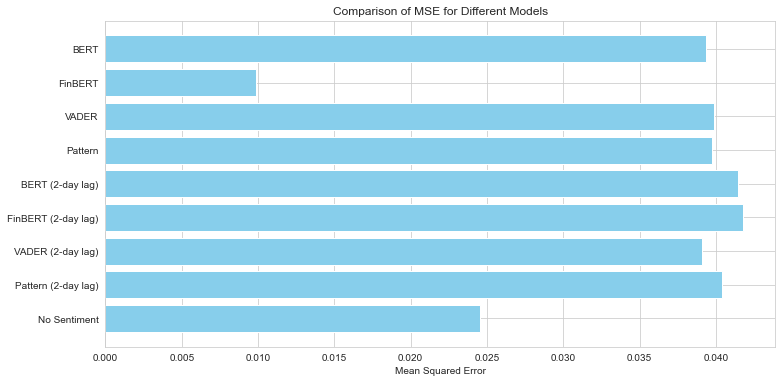

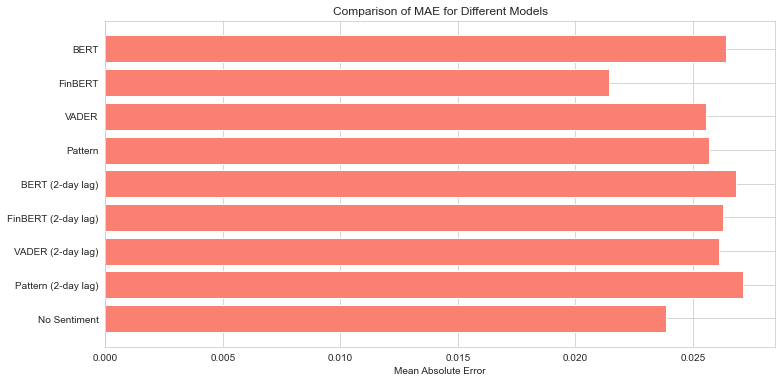

                 Model       MSE       MAE
0                 BERT  0.039328  0.026423
1              FinBERT  0.009844  0.021425
2                VADER  0.039901  0.025571
3              Pattern  0.039726  0.025691
4     BERT (2-day lag)  0.041472  0.026857
5  FinBERT (2-day lag)  0.041790  0.026287
6    VADER (2-day lag)  0.039113  0.026115
7  Pattern (2-day lag)  0.040426  0.027143
8         No Sentiment  0.024557  0.023872

Most Performant Model based on MSE: FinBERT
Most Performant Model based on MAE: FinBERT


In [182]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have the MSE and MAE values for each model
data = {
    'Model': ['BERT', 'FinBERT', 'VADER', 'Pattern', 'BERT (2-day lag)', 'FinBERT (2-day lag)', 'VADER (2-day lag)', 'Pattern (2-day lag)', 'No Sentiment'],
    'MSE': [mse, mse_finbert, mse_vader, mse_pattern, mse_lagged, mse2_lagged, mse3_lagged, mse4_lagged, mse_no_sentiment],
    'MAE': [mae, mae_finbert, mae_vader, mae_pattern, mae_lagged, mae2_lagged, mae3_lagged, mae4_lagged, mae_no_sentiment]
}

df = pd.DataFrame(data)

# Bar chart for MSE
plt.figure(figsize=(12, 6))
plt.barh(df['Model'], df['MSE'], color='skyblue')
plt.xlabel('Mean Squared Error')
plt.title('Comparison of MSE for Different Models')
plt.gca().invert_yaxis()  # To have the models appear in the order you provided
plt.show()

# Bar chart for MAE
plt.figure(figsize=(12, 6))
plt.barh(df['Model'], df['MAE'], color='salmon')
plt.xlabel('Mean Absolute Error')
plt.title('Comparison of MAE for Different Models')
plt.gca().invert_yaxis()
plt.show()

# Displaying table
print(df)

# Identify the best model based on MSE and MAE
best_model_mse = df['Model'][df['MSE'].idxmin()]
best_model_mae = df['Model'][df['MAE'].idxmin()]

print("\nMost Performant Model based on MSE:", best_model_mse)
print("Most Performant Model based on MAE:", best_model_mae)


## Loss function plot

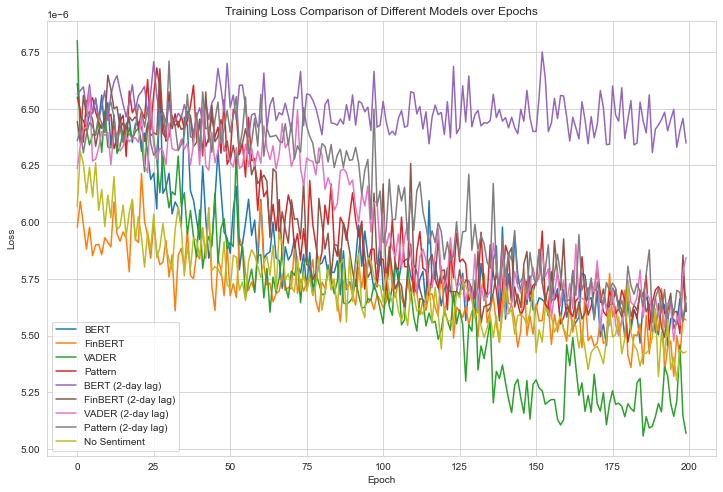

In [184]:
# Assuming you've already defined and compiled each of your models...

# Train each model and capture its history
history_bert = model.fit(train_X, train_y, epochs=200, verbose=0)
history_finbert = model_finbert.fit(train_X_finbert, train_y_finbert, epochs=200, verbose=0)
history_vader = model_vader.fit(train_X_vader, train_y_vader, epochs=200, verbose=0)
history_pattern = model_pattern.fit(train_X_pattern, train_y_pattern, epochs=200, verbose=0)

history_bert_lagged = model_lagged.fit(train_X_lagged, train_y_lagged, epochs=200, verbose=0)
history_finbert_lagged = model2_lagged.fit(train_X2_lagged, train_y2_lagged, epochs=200, verbose=0)
history_vader_lagged = model3_lagged.fit(train_X3_lagged, train_y3_lagged, epochs=200, verbose=0)
history_pattern_lagged = model4_lagged.fit(train_X4_lagged, train_y4_lagged, epochs=200, verbose=0)

history_no_sentiment = model_no_sentiment.fit(train_X_no_sentiment, train_y_no_sentiment, epochs=200, verbose=0)

# Plot the training loss for all models together for comparison
plt.figure(figsize=(12,8))

# Plotting loss for each model
plt.plot(history_bert.history['loss'], label='BERT')
plt.plot(history_finbert.history['loss'], label='FinBERT')
plt.plot(history_vader.history['loss'], label='VADER')
plt.plot(history_pattern.history['loss'], label='Pattern')
plt.plot(history_bert_lagged.history['loss'], label='BERT (2-day lag)')
plt.plot(history_finbert_lagged.history['loss'], label='FinBERT (2-day lag)')
plt.plot(history_vader_lagged.history['loss'], label='VADER (2-day lag)')
plt.plot(history_pattern_lagged.history['loss'], label='Pattern (2-day lag)')
plt.plot(history_no_sentiment.history['loss'], label='No Sentiment')

# Add titles, labels, and legend
plt.title('Training Loss Comparison of Different Models over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Display the plot
plt.show()